# Morocco Education Data Analysis (2000-2030)
## Executive Summary

This comprehensive analysis examines Morocco's education system evolution from 2000 to 2024 and provides strategic forecasts for 2025-2030. The study encompasses enrollment trends, completion rates, equity metrics, resource allocation, and policy impacts across primary, secondary, and tertiary education levels.

### Key Findings Preview
- **Enrollment Growth**: Significant expansion across all education levels with notable gender parity improvements
- **Completion Challenges**: Persistent dropout rates at critical transition points, particularly primary to secondary
- **Equity Progress**: Steady reduction in gender gaps, though rural-urban disparities remain
- **Resource Constraints**: Declining pupil-teacher ratios but persistent capacity gaps in higher education
- **Policy Impact**: Clear correlation between education reforms and enrollment/completion improvements

### Methodology
The analysis employs time series forecasting, statistical correlation analysis, and scenario modeling to provide evidence-based insights for policy formulation and resource allocation decisions.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
import plotly.offline as pyo

# Set display options and styling
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configure plotly for offline use
pyo.init_notebook_mode(connected=True)
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


Analysis started at: 2025-09-14 16:34:24


## 1. Data Overview & Preparation

This section provides a comprehensive examination of the Morocco education dataset, including data quality assessment, variable identification, and preparation for analysis.


In [2]:
# Load and inspect the dataset
data_path = '/Users/hafida/Downloads/Education/morocco_education_comprehensive_merged.csv'
df = pd.read_csv(data_path)

print("Dataset loaded successfully")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"Data types:\n{df.dtypes}")
df.head()


Dataset loaded successfully
Dataset shape: (846, 13)
Columns: ['year', 'indicator_code', 'indicator_name', 'value', 'category', 'country', 'source', 'education_level', 'quality_flag', 'data_source', 'validation_status', 'data_quality_flag', 'gender_disaggregation']
Data types:
year                      int64
indicator_code           object
indicator_name           object
value                    object
category                 object
country                  object
source                   object
education_level          object
quality_flag             object
data_source              object
validation_status        object
data_quality_flag        object
gender_disaggregation    object
dtype: object


,year,indicator_code,indicator_name,value,category,country,source,education_level,quality_flag,data_source,validation_status,data_quality_flag,gender_disaggregation
0,1990,SE.TER.ENRL.WIDE,Tertiary enrollment total (wide format),198000.0,strategic_enrollment,Morocco,enrollment_dataset,TERTIARY,WIDE_FORMAT,enrollment_dataset,WIDE_FORMAT,WIDE_FORMAT,TOTAL
1,2000,NY.GDP.MKTP.KD.ZG,GDP growth annual,2.58218091499747,strategic_enrollment,Morocco,NaN,NaN,NaN,NaN,NaN,GOOD,TOTAL
2,2000,NY.GDP.PCAP.CD,GDP per capita,1499.107421875,strategic_enrollment,Morocco,NaN,NaN,NaN,NaN,NaN,GOOD,TOTAL
3,2000,SE.ENR.PRIM.FM.ZS,Female to male enrollment primary,0.849709987640381,equity_gender,Morocco,NaN,NaN,NaN,NaN,NaN,GOOD,TOTAL
4,2000,SE.ENR.SECO.FM.ZS,Female to male enrollment secondary,0.799099981784821,equity_gender,Morocco,NaN,NaN,NaN,NaN,NaN,GOOD,TOTAL


In [3]:
# Analyzing the structure of the dataset
print("- DATASET STRUCTURE ANALYSIS")

# Displaying the total number of records
total_records = len(df)
print(f"Total records: {total_records:,}")

# Showing the time period covered by the dataset
start_year = df['year'].min()
end_year = df['year'].max()
print(f"Time period: {start_year} - {end_year}")

# Counting unique indicators and categories
unique_indicators = df['indicator_code'].nunique()
unique_categories = df['category'].nunique()
print(f"Unique indicators: {unique_indicators}")
print(f"Unique categories: {unique_categories}")

# Checking the distribution of data quality
print("Data quality distribution:")
data_quality_distribution = df['data_quality_flag'].value_counts()
print(data_quality_distribution)

print("\n - INDICATOR CATEGORIES")
# Listing the number of records per category
category_counts = df['category'].value_counts()
for category, count in category_counts.items():
    print(f"{category}: {count} records")

print("\n### EDUCATION LEVELS")
# Displaying the distribution of education levels
education_levels = df['education_level'].value_counts()
print(education_levels)

- DATASET STRUCTURE ANALYSIS
Total records: 846
Time period: 1990 - 2024
Unique indicators: 86
Unique categories: 16
Data quality distribution:
data_quality_flag
GOOD           818
EXCELLENT       21
WIDE_FORMAT      7
Name: count, dtype: int64

 - INDICATOR CATEGORIES
strategic_enrollment: 245 records
equity_gender: 160 records
operational_completion: 90 records
labor_higher_ed: 82 records
strategic_capacity: 59 records
diagnostics_factors: 55 records
operational_access: 45 records
strategic_budget: 41 records
operational_quality: 33 records
learning_outcomes: 12 records
completion_outcomes: 7 records
regional_equity: 6 records
financial_investment: 5 records
digital_education: 3 records
socioeconomic_equity: 2 records
equity_special_needs: 1 records

### EDUCATION LEVELS
education_level
SECONDARY_UPPER    34
PRIMARY            11
SECONDARY           6
ALL_LEVELS          6
SECONDARY_LOWER     5
TERTIARY            4
PRE_PRIMARY         3
TVET                3
ADULT_EDUCATION     2
Na

In [4]:
# Convert 'value' column to numeric, handling errors by converting to NaN
df['value'] = pd.to_numeric(df['value'], errors='coerce')

# Key variables identification and data quality assessment
print(" ### KEY VARIABLES IDENTIFICATION")

# Group indicators by category for in-depth analysis
strategic_indicators = df[df['category'] == 'strategic_enrollment']['indicator_code'].unique()
equity_indicators = df[df['category'] == 'equity_gender']['indicator_code'].unique()
completion_indicators = df[df['category'] == 'operational_completion']['indicator_code'].unique()
budget_indicators = df[df['category'] == 'strategic_budget']['indicator_code'].unique()
capacity_indicators = df[df['category'] == 'strategic_capacity']['indicator_code'].unique()

# Report the number of unique indicators in each category
print(f"Number of strategic enrollment indicators: {len(strategic_indicators)}")
print(f"Number of equity/gender indicators: {len(equity_indicators)}")
print(f"Number of completion indicators: {len(completion_indicators)}")
print(f"Number of budget indicators: {len(budget_indicators)}")
print(f"Number of capacity indicators: {len(capacity_indicators)}")

print("\n### Data Quality Assessment")
print("Missing values per column:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0])

# Check for duplicate records
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate records: {duplicates}")

print("\n### Value Ranges for Key Metrics")
# Define the list of numeric indicators to analyze
numeric_indicators = ['SE.PRM.ENRL', 'SE.SEC.ENRL', 'SE.TER.ENRL', 'SE.PRM.CMPT.ZS', 'SE.SEC.CMPT.LO.ZS']
for indicator in numeric_indicators:
    if indicator in df['indicator_code'].values:
        # Extract non-missing values for the current indicator
        values = df[df['indicator_code'] == indicator]['value'].dropna()
        print(f"{indicator}: Min = {values.min():.2f}, Max = {values.max():.2f}")

 ### KEY VARIABLES IDENTIFICATION
Number of strategic enrollment indicators: 13
Number of equity/gender indicators: 9
Number of completion indicators: 4
Number of budget indicators: 4
Number of capacity indicators: 4

### Data Quality Assessment
Missing values per column:
value                  3
source               772
education_level      772
quality_flag         772
data_source          772
validation_status    772
dtype: int64

Number of duplicate records: 0

### Value Ranges for Key Metrics
SE.PRM.ENRL: Min = 3669605.00, Max = 4683013.00
SE.SEC.ENRL: Min = 1541100.00, Max = 3434273.00
SE.TER.ENRL: Min = 295634.00, Max = 1120285.00
SE.PRM.CMPT.ZS: Min = 58.70, Max = 104.69
SE.SEC.CMPT.LO.ZS: Min = 33.73, Max = 74.21


In [5]:
print("### Data Cleaning and Preparation")

# Filter data to include only the analysis period (2000-2024)
df_analysis = df[(df['year'] >= 2000) & (df['year'] <= 2024)].copy()
print(f"Analysis period data: {len(df_analysis):,} records")
print(f"Available years: {df_analysis['year'].min()} - {df_analysis['year'].max()}")

# Verify the presence of tertiary enrollment data
tertiary_data = df_analysis[df_analysis['indicator_code'] == 'SE.TER.ENRL']
print(f"Tertiary enrollment data points: {len(tertiary_data)}")
if len(tertiary_data) > 0:
    print(f"Tertiary enrollment years: {sorted(tertiary_data['year'].unique())}")

### Data Cleaning and Preparation
Analysis period data: 845 records
Available years: 2000 - 2024
Tertiary enrollment data points: 23
Tertiary enrollment years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2022), np.int64(2023)]


In [6]:
print(f"\n### New Comprehensive Indicators Added")
new_categories = ['completion_outcomes', 'learning_outcomes', 'regional_equity', 'socioeconomic_equity', 
                  'digital_education', 'financial_investment']
for category in new_categories:
    category_data = df_analysis[df_analysis['category'] == category]
    if len(category_data) > 0:
        print(f"{category}: {len(category_data)} indicators")

# Examine specific new indicators
completion_indicators = df_analysis[df_analysis['indicator_code'].str.contains('CMPT', na=False)]
learning_indicators = df_analysis[df_analysis['indicator_code'].str.contains('TIMSS|PISA', na=False)]
regional_indicators = df_analysis[df_analysis['indicator_code'].str.contains('RUR|URB', na=False)]

print(f"\nNew indicator categories:")
print(f"Completion metrics: {len(completion_indicators)} indicators")
print(f"Learning outcomes: {len(learning_indicators)} indicators") 
print(f"Regional disparities: {len(regional_indicators)} indicators")


### New Comprehensive Indicators Added
completion_outcomes: 7 indicators
learning_outcomes: 12 indicators
regional_equity: 6 indicators
socioeconomic_equity: 2 indicators
digital_education: 3 indicators
financial_investment: 5 indicators

New indicator categories:
Completion metrics: 171 indicators
Learning outcomes: 12 indicators
Regional disparities: 58 indicators


In [7]:
# Define a function to create pivot tables for specific indicators
def create_pivot_table(df, indicator_code, indicator_name):
    """Create pivot table for specific indicator"""
    filtered = df[df['indicator_code'] == indicator_code].copy()
    if len(filtered) > 0:
        # Handle text values in tertiary enrollment data
        if indicator_code == 'SE.TER.ENRL':
            # Clean the value column to extract numeric values
            filtered['value_clean'] = filtered['value'].astype(str).str.extract('(\d+(?:\.\d+)?)').astype(float)
            pivot = filtered.pivot_table(
                index='year', 
                values='value_clean', 
                aggfunc='mean'
            ).rename(columns={'value_clean': indicator_name})
        else:
            pivot = filtered.pivot_table(
                index='year', 
                values='value', 
                aggfunc='mean'
            ).rename(columns={'value': indicator_name})
        return pivot
    return pd.DataFrame()

# Define key indicators for analysis
key_indicators = {
    'SE.PRM.ENRL': 'Primary Enrollment',
    'SE.SEC.ENRL': 'Secondary Enrollment', 
    'SE.TER.ENRL': 'Tertiary Enrollment',
    'SE.PRM.CMPT.ZS': 'Primary Completion Rate',
    'SE.SEC.CMPT.LO.ZS': 'Lower Secondary Completion Rate',
    'SE.PRM.NENR': 'Primary Net Enrollment Rate',
    'SE.ENR.PRIM.FM.ZS': 'Gender Parity Index Primary',
    'SE.ENR.SECO.FM.ZS': 'Gender Parity Index Secondary',
    'SE.ENR.TERT.FM.ZS': 'Gender Parity Index Tertiary',
    'SP.POP.TOTL': 'Total Population',
    'NY.GDP.PCAP.CD': 'GDP per Capita',
    'SE.XPD.PRIM.PC.ZS': 'Expenditure per Student Primary',
    'SE.PRE.CMPT.ZS': 'Preschool Completion Rate',
    'SE.PRM.CMPT.ACT.ZS': 'Primary Completion Rate (Actual)',
    'SE.SEC.LO.CMPT.ZS': 'Lower Secondary Completion Rate',
    'SE.SEC.UP.CMPT.ZS': 'Upper Secondary Completion Rate',
    'SE.SEC.UP.CMPT.FE.ZS': 'Upper Secondary Completion Rate Female',
    'SE.SEC.UP.CMPT.MA.ZS': 'Upper Secondary Completion Rate Male',
    'TIMSS_G4_MATH_2023': 'TIMSS Grade 4 Mathematics',
    'TIMSS_G8_MATH_2023': 'TIMSS Grade 8 Mathematics',
    'TIMSS_G8_SCIENCE_2023': 'TIMSS Grade 8 Science',
    'PISA_MATH_2022': 'PISA Mathematics 2022',
    'PISA_READ_2022': 'PISA Reading 2022',
    'PISA_SCI_2022': 'PISA Science 2022',
    'SE.PRM.ENRL.RUR.ZS': 'Primary Enrollment Rural',
    'SE.PRM.ENRL.URB.ZS': 'Primary Enrollment Urban',
    'SE.SEC.ENRL.RUR.ZS': 'Secondary Enrollment Rural',
    'SE.SEC.ENRL.URB.ZS': 'Secondary Enrollment Urban',
    'SE.PRE.ENRL.RUR.ZS': 'Preschool Enrollment Rural',
    'SE.PRE.ENRL.URB.ZS': 'Preschool Enrollment Urban',
    'SE.PRM.ENRL.POOR.ZS': 'Primary Enrollment (Poorest Quintile)',
    'SE.PRM.ENRL.RICH.ZS': 'Primary Enrollment (Richest Quintile)',
    'SE.LIT.RATE.RUR.F': 'Female Literacy Rate Rural',
    'SE.LIT.RATE.URB.F': 'Female Literacy Rate Urban',
    'SE.TVET.ENRL.TOTAL': 'TVET Total Enrollment',
    'SE.YOUTH.NEET.ZS': 'Youth NEET Rate',
    'SE.XPD.GDP.TOTAL.ZS': 'Education Expenditure % GDP',
    'SE.XPD.STUDENT.PRIMARY': 'Per-student Expenditure Primary',
    'SE.XPD.STUDENT.SECONDARY': 'Per-student Expenditure Secondary',
    'SE.XPD.STUDENT.TERTIARY': 'Per-student Expenditure Tertiary',
    'SE.DIGITAL.ACCESS.ZS': 'Students with Digital Access',
    'SE.SCHOOL.INTERNET.ZS': 'Schools with Internet',
    'SE.DISTANCE.LEARN.COVID': 'Distance Learning Effectiveness COVID'
}

# Create comprehensive dataset for analysis
analysis_data = pd.DataFrame({'year': range(2000, 2025)})

for indicator_code, indicator_name in key_indicators.items():
    pivot = create_pivot_table(df_analysis, indicator_code, indicator_name)
    if not pivot.empty:
        analysis_data = analysis_data.merge(pivot, on='year', how='left')

print(f"Prepared analysis dataset with {len(analysis_data)} years and {len(analysis_data.columns)-1} indicators")
print(f"Columns: {list(analysis_data.columns)}")

Prepared analysis dataset with 25 years and 43 indicators
Columns: ['year', 'Primary Enrollment', 'Secondary Enrollment', 'Tertiary Enrollment', 'Primary Completion Rate', 'Lower Secondary Completion Rate_x', 'Primary Net Enrollment Rate', 'Gender Parity Index Primary', 'Gender Parity Index Secondary', 'Gender Parity Index Tertiary', 'Total Population', 'GDP per Capita', 'Expenditure per Student Primary', 'Preschool Completion Rate', 'Primary Completion Rate (Actual)', 'Lower Secondary Completion Rate_y', 'Upper Secondary Completion Rate', 'Upper Secondary Completion Rate Female', 'Upper Secondary Completion Rate Male', 'TIMSS Grade 4 Mathematics', 'TIMSS Grade 8 Mathematics', 'TIMSS Grade 8 Science', 'PISA Mathematics 2022', 'PISA Reading 2022', 'PISA Science 2022', 'Primary Enrollment Rural', 'Primary Enrollment Urban', 'Secondary Enrollment Rural', 'Secondary Enrollment Urban', 'Preschool Enrollment Rural', 'Preschool Enrollment Urban', 'Primary Enrollment (Poorest Quintile)', 'Prim

In [8]:
print(f"\n### Data Completeness by Indicator:")
for col in analysis_data.columns:
    if col != 'year':
        completeness = (1 - analysis_data[col].isnull().sum() / len(analysis_data)) * 100
        print(f"{col}: {completeness:.1f}%")


### Data Completeness by Indicator:
Primary Enrollment: 96.0%
Secondary Enrollment: 80.0%
Tertiary Enrollment: 80.0%
Primary Completion Rate: 96.0%
Lower Secondary Completion Rate_x: 92.0%
Primary Net Enrollment Rate: 72.0%
Gender Parity Index Primary: 88.0%
Gender Parity Index Secondary: 72.0%
Gender Parity Index Tertiary: 96.0%
Total Population: 100.0%
GDP per Capita: 100.0%
Expenditure per Student Primary: 56.0%
Preschool Completion Rate: 4.0%
Primary Completion Rate (Actual): 4.0%
Lower Secondary Completion Rate_y: 4.0%
Upper Secondary Completion Rate: 4.0%
Upper Secondary Completion Rate Female: 4.0%
Upper Secondary Completion Rate Male: 4.0%
TIMSS Grade 4 Mathematics: 4.0%
TIMSS Grade 8 Mathematics: 4.0%
TIMSS Grade 8 Science: 4.0%
PISA Mathematics 2022: 4.0%
PISA Reading 2022: 4.0%
PISA Science 2022: 4.0%
Primary Enrollment Rural: 4.0%
Primary Enrollment Urban: 4.0%
Secondary Enrollment Rural: 4.0%
Secondary Enrollment Urban: 4.0%
Preschool Enrollment Rural: 4.0%
Preschool Enro

## 2. Historical Analysis (2000-2024)

This section provides a comprehensive analysis of Morocco's education system evolution over the past two decades, examining enrollment trends, completion rates, equity metrics, resource allocation, and policy impacts.


### 2.1 Enrollment & Access Analysis


In [9]:
print("### Handling Missing Columns")

# Display available columns related to completion metrics
print("Available completion-related columns:")
completion_cols = [col for col in analysis_data.columns if 'Completion' in col]
for col in completion_cols:
    print(f"  {col}")

### Handling Missing Columns
Available completion-related columns:
  Primary Completion Rate
  Lower Secondary Completion Rate_x
  Preschool Completion Rate
  Primary Completion Rate (Actual)
  Lower Secondary Completion Rate_y
  Upper Secondary Completion Rate
  Upper Secondary Completion Rate Female
  Upper Secondary Completion Rate Male


In [10]:
# Enrollment trends by education level
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Primary Enrollment', 'Secondary Enrollment', 
                   'Tertiary Enrollment', 'Enrollment Growth Rates'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": True}]]
)

# Primary enrollment
fig.add_trace(
    go.Scatter(x=analysis_data['year'], y=analysis_data['Primary Enrollment']/1000000,
               mode='lines+markers', name='Primary (Millions)',
               line=dict(color='#1f77b4', width=3)),
    row=1, col=1
)

# Secondary enrollment
fig.add_trace(
    go.Scatter(x=analysis_data['year'], y=analysis_data['Secondary Enrollment']/1000000,
               mode='lines+markers', name='Secondary (Millions)',
               line=dict(color='#ff7f0e', width=3)),
    row=1, col=2
)

# Tertiary enrollment
fig.add_trace(
    go.Scatter(x=analysis_data['year'], y=analysis_data['Tertiary Enrollment']/1000000,
               mode='lines+markers', name='Tertiary (Millions)',
               line=dict(color='#2ca02c', width=3)),
    row=2, col=1
)

# Calculate growth rates
analysis_data['Primary Growth'] = analysis_data['Primary Enrollment'].pct_change() * 100
analysis_data['Secondary Growth'] = analysis_data['Secondary Enrollment'].pct_change() * 100
analysis_data['Tertiary Growth'] = analysis_data['Tertiary Enrollment'].pct_change() * 100

# Growth rates
fig.add_trace(
    go.Scatter(x=analysis_data['year'], y=analysis_data['Primary Growth'],
               mode='lines+markers', name='Primary Growth %',
               line=dict(color='#1f77b4', width=2)),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(x=analysis_data['year'], y=analysis_data['Secondary Growth'],
               mode='lines+markers', name='Secondary Growth %',
               line=dict(color='#ff7f0e', width=2)),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(x=analysis_data['year'], y=analysis_data['Tertiary Growth'],
               mode='lines+markers', name='Tertiary Growth %',
               line=dict(color='#2ca02c', width=2)),
    row=2, col=2
)

fig.update_layout(
    title="Enrollment Trends by Education Level (2000-2024)",
    height=600,
    showlegend=True
)

fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_xaxes(title_text="Year", row=2, col=2)
fig.update_yaxes(title_text="Students (Millions)", row=1, col=1)
fig.update_yaxes(title_text="Students (Millions)", row=1, col=2)
fig.update_yaxes(title_text="Students (Millions)", row=2, col=1)
fig.update_yaxes(title_text="Growth Rate (%)", row=2, col=2)

fig.show()

In [11]:
print("### Enrollment Statistical Summary")
enrollment_summary = analysis_data[['Primary Enrollment', 'Secondary Enrollment', 'Tertiary Enrollment']].describe()
enrollment_summary

### Enrollment Statistical Summary


,Primary Enrollment,Secondary Enrollment,Tertiary Enrollment
count,2.400000e+01,2.000000e+01,2.000000e+01
mean,4.121491e+06,2.399989e+06,5.823387e+05
std,2.724732e+05,5.724121e+05,2.857168e+05
min,3.669605e+06,1.541100e+06,2.956340e+05
25%,3.944858e+06,1.930875e+06,3.617508e+05
50%,4.029627e+06,2.361962e+06,4.330625e+05
75%,4.238663e+06,2.883480e+06,8.114062e+05
max,4.683013e+06,3.434273e+06,1.120285e+06


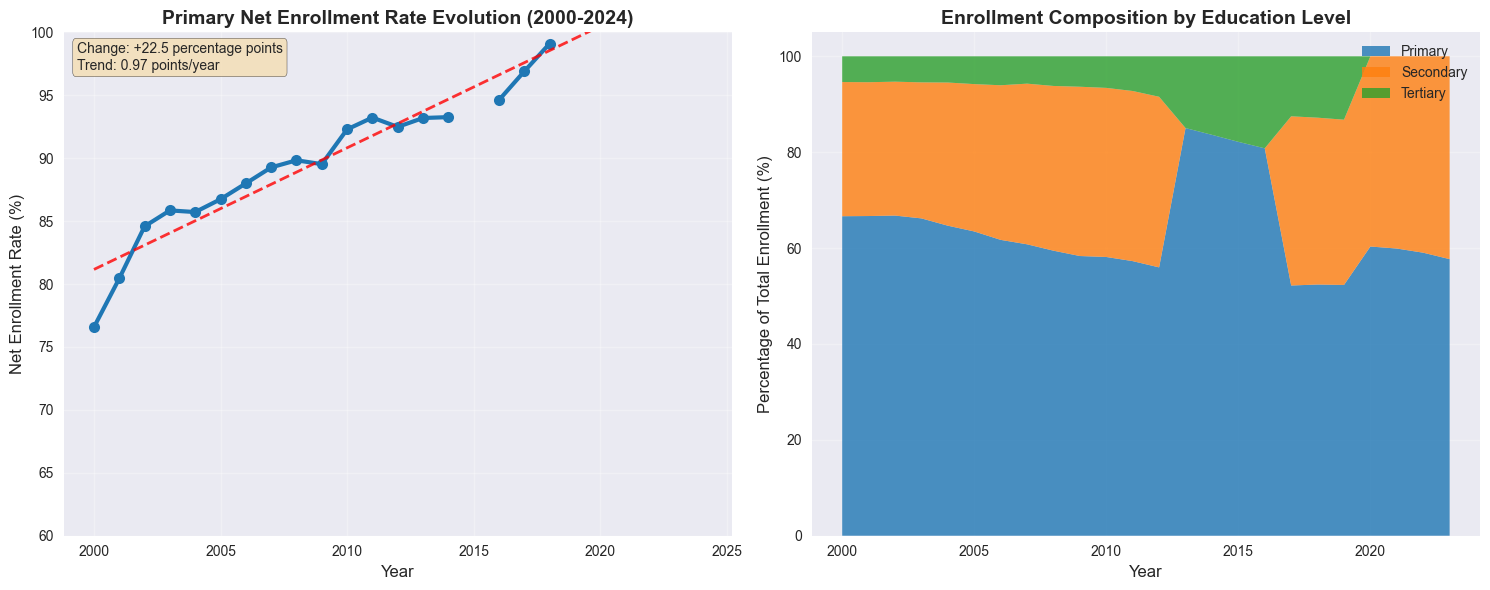

In [12]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Primary NER trend
ax1.plot(analysis_data['year'], analysis_data['Primary Net Enrollment Rate'], 
         marker='o', linewidth=3, markersize=8, color='#1f77b4')
ax1.set_title('Primary Net Enrollment Rate Evolution (2000-2024)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Net Enrollment Rate (%)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(60, 100)

# Add trend line and display trend
valid_data = analysis_data[['year', 'Primary Net Enrollment Rate']].dropna()
if len(valid_data) > 1:
    z = np.polyfit(valid_data['year'], valid_data['Primary Net Enrollment Rate'], 1)
    p = np.poly1d(z)
    ax1.plot(analysis_data['year'], p(analysis_data['year']), "--", alpha=0.8, color='red', linewidth=2)
    
    start_ner = valid_data['Primary Net Enrollment Rate'].iloc[0]
    end_ner = valid_data['Primary Net Enrollment Rate'].iloc[-1]
    change = end_ner - start_ner
    ax1.text(0.02, 0.98, f'Change: +{change:.1f} percentage points\nTrend: {z[0]:.2f} points/year', 
             transform=ax1.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
else:
    start_ner = analysis_data['Primary Net Enrollment Rate'].dropna().iloc[0] if not analysis_data['Primary Net Enrollment Rate'].dropna().empty else 0
    end_ner = analysis_data['Primary Net Enrollment Rate'].dropna().iloc[-1] if not analysis_data['Primary Net Enrollment Rate'].dropna().empty else 0
    change = end_ner - start_ner
    ax1.text(0.02, 0.98, f'Change: +{change:.1f} percentage points\nInsufficient data for trend', 
             transform=ax1.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot enrollment composition over time
enrollment_cols = ['Primary Enrollment', 'Secondary Enrollment', 'Tertiary Enrollment']
enrollment_data = analysis_data[enrollment_cols].fillna(0)
total_enrollment = enrollment_data.sum(axis=1)
percentages = enrollment_data.div(total_enrollment, axis=0) * 100

ax2.stackplot(analysis_data['year'], 
              percentages['Primary Enrollment'],
              percentages['Secondary Enrollment'], 
              percentages['Tertiary Enrollment'],
              labels=['Primary', 'Secondary', 'Tertiary'],
              colors=['#1f77b4', '#ff7f0e', '#2ca02c'],
              alpha=0.8)

ax2.set_title('Enrollment Composition by Education Level', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Percentage of Total Enrollment (%)', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
# Key insights
print("ENROLLMENT INSIGHTS")
print(f"Primary NER improvement: {start_ner:.1f}% → {end_ner:.1f}% (+{change:.1f} points)")
if len(valid_data) > 1:
    print(f"Average annual improvement: {z[0]:.2f} percentage points")
else:
    print("Average annual improvement: Insufficient data for trend calculation")

# Calculate transition rates
primary_peak = analysis_data['Primary Enrollment'].max()
secondary_peak = analysis_data['Secondary Enrollment'].max()
tertiary_peak = analysis_data['Tertiary Enrollment'].max()

primary_to_secondary = (secondary_peak / primary_peak) * 100
secondary_to_tertiary = (tertiary_peak / secondary_peak) * 100

print(f"Primary to Secondary transition rate: {primary_to_secondary:.1f}%")
print(f"Secondary to Tertiary transition rate: {secondary_to_tertiary:.1f}%")

# Analyze updated tertiary enrollment data
print(f"UPDATED TERTIARY ENROLLMENT ANALYSIS")
tertiary_analysis = analysis_data[['year', 'Tertiary Enrollment']].dropna()
if len(tertiary_analysis) > 0:
    print(f"Tertiary enrollment data available for {len(tertiary_analysis)} years")
    print(f"Latest tertiary enrollment: {tertiary_analysis['Tertiary Enrollment'].iloc[-1]:,.0f} students")
    
    # Calculate tertiary growth
    if len(tertiary_analysis) > 1:
        first_year = tertiary_analysis['year'].iloc[0]
        last_year = tertiary_analysis['year'].iloc[-1]
        first_enrollment = tertiary_analysis['Tertiary Enrollment'].iloc[0]
        last_enrollment = tertiary_analysis['Tertiary Enrollment'].iloc[-1]
        
        total_growth = ((last_enrollment / first_enrollment) - 1) * 100
        annual_growth = ((last_enrollment / first_enrollment) ** (1/(last_year - first_year)) - 1) * 100
        
        print(f"Total tertiary growth ({first_year}-{last_year}): {total_growth:.1f}%")
        print(f"Annual tertiary growth rate: {annual_growth:.1f}%")
        
        # Recent trends (last 5 years if available)
        if len(tertiary_analysis) >= 5:
            recent_data = tertiary_analysis.tail(5)
            recent_growth = ((recent_data['Tertiary Enrollment'].iloc[-1] / recent_data['Tertiary Enrollment'].iloc[0]) - 1) * 100
            print(f"Recent tertiary growth (last 5 years): {recent_growth:.1f}%")

ENROLLMENT INSIGHTS
Primary NER improvement: 76.6% → 99.1% (+22.5 points)
Average annual improvement: 0.97 percentage points
Primary to Secondary transition rate: 73.3%
Secondary to Tertiary transition rate: 32.6%
UPDATED TERTIARY ENROLLMENT ANALYSIS
Tertiary enrollment data available for 20 years
Latest tertiary enrollment: 1,120,285 students
Total tertiary growth (2000-2019): 278.9%
Annual tertiary growth rate: 7.3%
Recent tertiary growth (last 5 years): 27.7%


In [14]:
# Display available columns in analysis_data
print("### Available Columns in analysis_data")
print(f"Total columns: {len(analysis_data.columns)}")

# Check columns related to completion metrics
print("\nColumns containing 'Completion':")
completion_cols = [col for col in analysis_data.columns if 'Completion' in col]
for col in completion_cols:
    print(f"  {col}")

# Display all columns in analysis_data
print("\nAll analysis_data columns:")
for i, col in enumerate(analysis_data.columns):
    print(f"  {i+1:2d}. {col}")

### Available Columns in analysis_data
Total columns: 47

Columns containing 'Completion':
  Primary Completion Rate
  Lower Secondary Completion Rate_x
  Preschool Completion Rate
  Primary Completion Rate (Actual)
  Lower Secondary Completion Rate_y
  Upper Secondary Completion Rate
  Upper Secondary Completion Rate Female
  Upper Secondary Completion Rate Male

All analysis_data columns:
   1. year
   2. Primary Enrollment
   3. Secondary Enrollment
   4. Tertiary Enrollment
   5. Primary Completion Rate
   6. Lower Secondary Completion Rate_x
   7. Primary Net Enrollment Rate
   8. Gender Parity Index Primary
   9. Gender Parity Index Secondary
  10. Gender Parity Index Tertiary
  11. Total Population
  12. GDP per Capita
  13. Expenditure per Student Primary
  14. Preschool Completion Rate
  15. Primary Completion Rate (Actual)
  16. Lower Secondary Completion Rate_y
  17. Upper Secondary Completion Rate
  18. Upper Secondary Completion Rate Female
  19. Upper Secondary Completion

In [15]:
# Print shape and first few rows of analysis_data
print(f"\nanalysis_data shape: {analysis_data.shape}")
analysis_data.head()


analysis_data shape: (25, 47)


,year,Primary Enrollment,Secondary Enrollment,Tertiary Enrollment,Primary Completion Rate,Lower Secondary Completion Rate_x,Primary Net Enrollment Rate,Gender Parity Index Primary,Gender Parity Index Secondary,Gender Parity Index Tertiary,Total Population,GDP per Capita,Expenditure per Student Primary,Preschool Completion Rate,Primary Completion Rate (Actual),Lower Secondary Completion Rate_y,Upper Secondary Completion Rate,Upper Secondary Completion Rate Female,Upper Secondary Completion Rate Male,TIMSS Grade 4 Mathematics,TIMSS Grade 8 Mathematics,TIMSS Grade 8 Science,PISA Mathematics 2022,PISA Reading 2022,PISA Science 2022,Primary Enrollment Rural,Primary Enrollment Urban,Secondary Enrollment Rural,Secondary Enrollment Urban,Preschool Enrollment Rural,Preschool Enrollment Urban,Primary Enrollment (Poorest Quintile),Primary Enrollment (Richest Quintile),Female Literacy Rate Rural,Female Literacy Rate Urban,TVET Total Enrollment,Youth NEET Rate,Education Expenditure % GDP,Per-student Expenditure Primary,Per-student Expenditure Secondary,Per-student Expenditure Tertiary,Students with Digital Access,Schools with Internet,Distance Learning Effectiveness COVID,Primary Growth,Secondary Growth,Tertiary Growth
0,2000,3669605.0,1541100.0,295634.0,58.699860,33.729679,76.57579,0.84971,0.79910,0.72415,28423435.0,1499.107422,17.25767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,3842000.0,1608279.0,311349.0,60.350361,35.339901,80.44593,0.87861,0.80625,0.75288,28814643.0,1506.245239,16.11648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.697917,4.359159,5.315694
2,2002,4029112.0,1685063.0,319309.0,62.073849,38.675579,84.58196,0.89678,0.81134,0.77624,29198142.0,1596.020630,16.33624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.870172,4.774296,2.556617
3,2003,4101157.0,1758057.0,336724.0,66.008881,39.758900,85.84979,0.90791,0.82642,0.77832,29571415.0,1941.872559,15.88767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.788111,4.331826,5.453965
4,2004,4070182.0,1879483.0,344335.0,74.042603,41.160069,85.71852,0.91045,0.83728,0.83531,29953018.0,2183.555420,15.96441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.755275,6.906830,2.260308


### 2.2 Completion & Transition Analysis


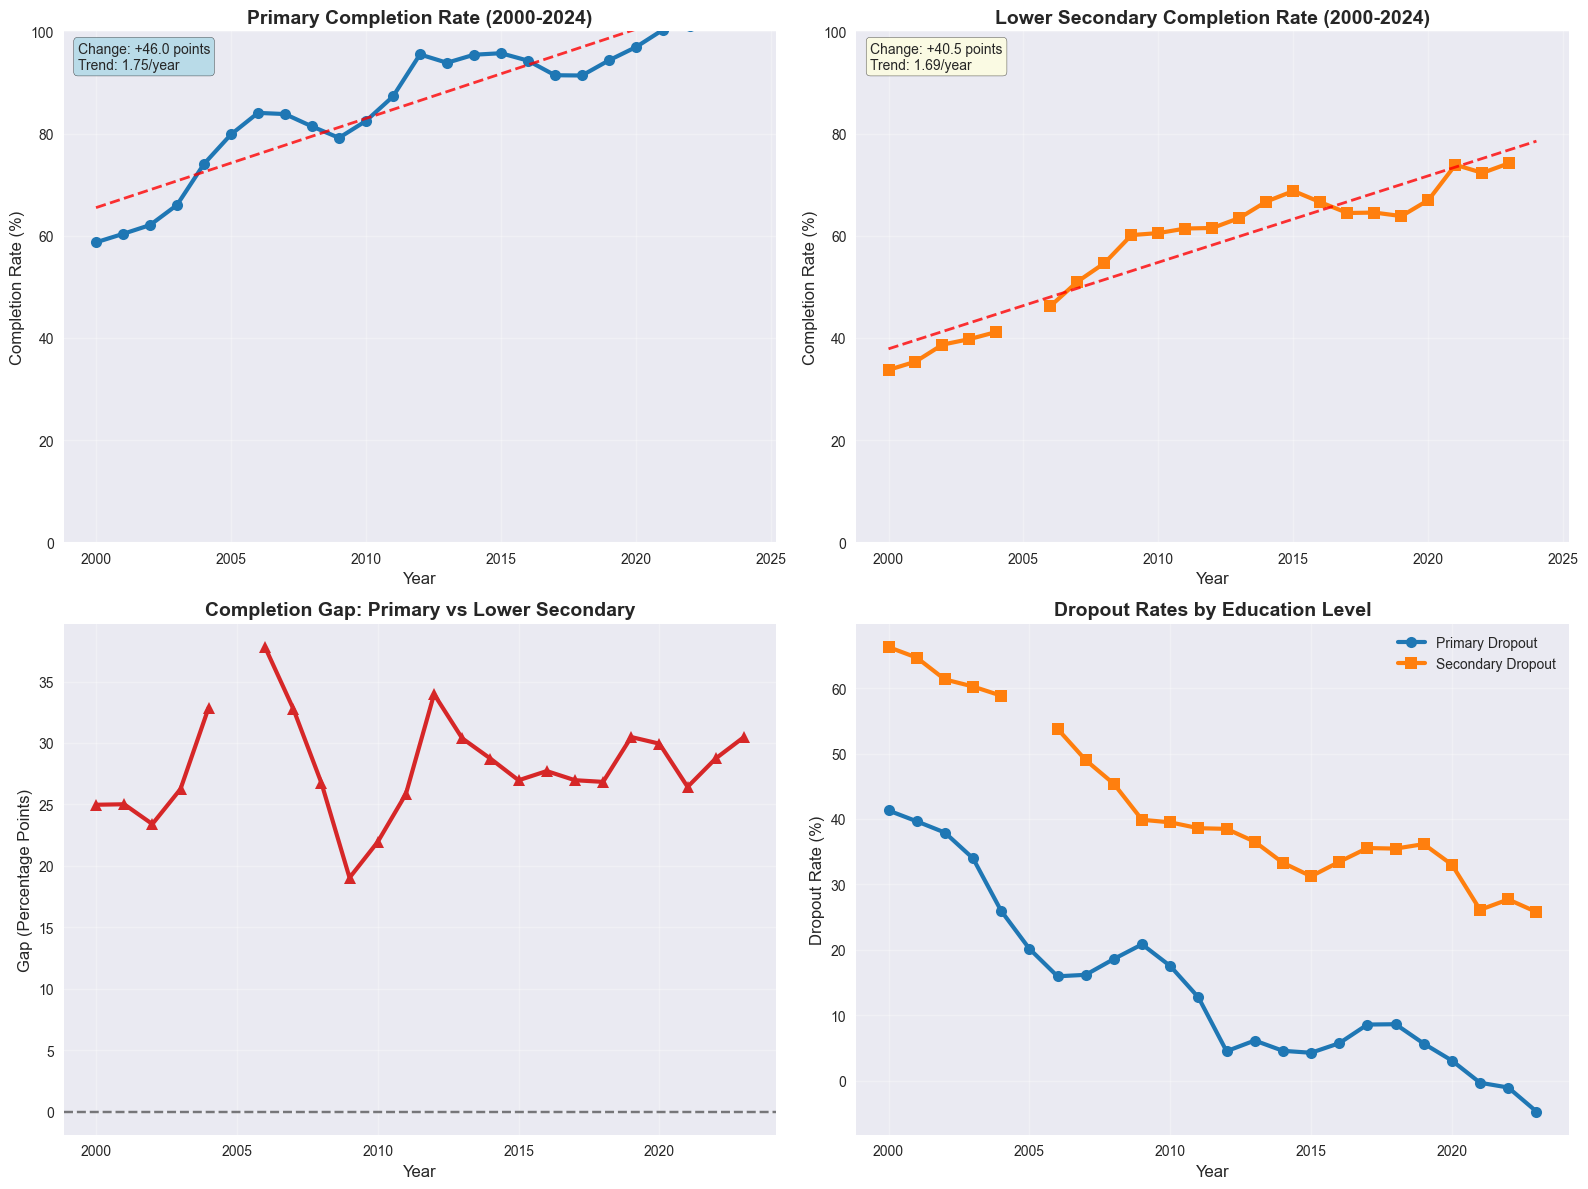

In [16]:
# Completion rates analysis with correct column names
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Primary completion rate
ax1.plot(analysis_data['year'], analysis_data['Primary Completion Rate'], 
         marker='o', linewidth=3, markersize=8, color='#1f77b4')
ax1.set_title('Primary Completion Rate (2000-2024)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Completion Rate (%)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 100)

# Add trend line and statistics
if not analysis_data['Primary Completion Rate'].isna().all():
    valid_primary = analysis_data[['year', 'Primary Completion Rate']].dropna()
    if len(valid_primary) > 1:
        z_primary = np.polyfit(valid_primary['year'], valid_primary['Primary Completion Rate'], 1)
        p_primary = np.poly1d(z_primary)
        ax1.plot(analysis_data['year'], p_primary(analysis_data['year']), "--", alpha=0.8, color='red', linewidth=2)
        
        start_primary = valid_primary['Primary Completion Rate'].iloc[0]
        end_primary = valid_primary['Primary Completion Rate'].iloc[-1]
        change_primary = end_primary - start_primary
        ax1.text(0.02, 0.98, f'Change: +{change_primary:.1f} points\nTrend: {z_primary[0]:.2f}/year', 
                 transform=ax1.transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    else:
        start_primary = analysis_data['Primary Completion Rate'].dropna().iloc[0] if not analysis_data['Primary Completion Rate'].dropna().empty else 0
        end_primary = analysis_data['Primary Completion Rate'].dropna().iloc[-1] if not analysis_data['Primary Completion Rate'].dropna().empty else 0
        change_primary = end_primary - start_primary
        ax1.text(0.02, 0.98, f'Change: +{change_primary:.1f} points\nInsufficient data for trend', 
                 transform=ax1.transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Lower secondary completion rate - using the correct column name with _x suffix
ax2.plot(analysis_data['year'], analysis_data['Lower Secondary Completion Rate_x'], 
         marker='s', linewidth=3, markersize=8, color='#ff7f0e')
ax2.set_title('Lower Secondary Completion Rate (2000-2024)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Completion Rate (%)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

if not analysis_data['Lower Secondary Completion Rate_x'].isna().all():
    valid_secondary = analysis_data[['year', 'Lower Secondary Completion Rate_x']].dropna()
    if len(valid_secondary) > 1:
        z_secondary = np.polyfit(valid_secondary['year'], valid_secondary['Lower Secondary Completion Rate_x'], 1)
        p_secondary = np.poly1d(z_secondary)
        ax2.plot(analysis_data['year'], p_secondary(analysis_data['year']), "--", alpha=0.8, color='red', linewidth=2)
        
        start_secondary = valid_secondary['Lower Secondary Completion Rate_x'].iloc[0]
        end_secondary = valid_secondary['Lower Secondary Completion Rate_x'].iloc[-1]
        change_secondary = end_secondary - start_secondary
        ax2.text(0.02, 0.98, f'Change: +{change_secondary:.1f} points\nTrend: {z_secondary[0]:.2f}/year', 
                 transform=ax2.transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    else:
        start_secondary = analysis_data['Lower Secondary Completion Rate_x'].dropna().iloc[0] if not analysis_data['Lower Secondary Completion Rate_x'].dropna().empty else 0
        end_secondary = analysis_data['Lower Secondary Completion Rate_x'].dropna().iloc[-1] if not analysis_data['Lower Secondary Completion Rate_x'].dropna().empty else 0
        change_secondary = end_secondary - start_secondary
        ax2.text(0.02, 0.98, f'Change: +{change_secondary:.1f} points\nInsufficient data for trend', 
                 transform=ax2.transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# Completion gap analysis - using correct column names
completion_gap = analysis_data['Primary Completion Rate'] - analysis_data['Lower Secondary Completion Rate_x']
ax3.plot(analysis_data['year'], completion_gap, 
         marker='^', linewidth=3, markersize=8, color='#d62728')
ax3.set_title('Completion Gap: Primary vs Lower Secondary', fontsize=14, fontweight='bold')
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('Gap (Percentage Points)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Dropout pattern identification
# Calculate dropout rates (simplified as 100 - completion rate)
primary_dropout = 100 - analysis_data['Primary Completion Rate']
secondary_dropout = 100 - analysis_data['Lower Secondary Completion Rate_x']

ax4.plot(analysis_data['year'], primary_dropout, 
         marker='o', linewidth=3, markersize=8, label='Primary Dropout', color='#1f77b4')
ax4.plot(analysis_data['year'], secondary_dropout, 
         marker='s', linewidth=3, markersize=8, label='Secondary Dropout', color='#ff7f0e')
ax4.set_title('Dropout Rates by Education Level', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year', fontsize=12)
ax4.set_ylabel('Dropout Rate (%)', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [17]:
# Transition analysis
print("### COMPLETION & TRANSITION ANALYSIS")
print(f"Primary completion improvement: {start_primary:.1f}% → {end_primary:.1f}% (+{change_primary:.1f} points)")
print(f"Secondary completion improvement: {start_secondary:.1f}% → {end_secondary:.1f}% (+{change_secondary:.1f} points)")

# Calculate average dropout rates
avg_primary_dropout = primary_dropout.mean()
avg_secondary_dropout = secondary_dropout.mean()
print(f"Average primary dropout rate: {avg_primary_dropout:.1f}%")
print(f"Average secondary dropout rate: {avg_secondary_dropout:.1f}%")

# Identify critical bottlenecks
max_gap = completion_gap.max()
min_gap = completion_gap.min()
print(f"Maximum completion gap: {max_gap:.1f} percentage points")
print(f"Gap reduction: {max_gap - min_gap:.1f} percentage points")

### COMPLETION & TRANSITION ANALYSIS
Primary completion improvement: 58.7% → 104.7% (+46.0 points)
Secondary completion improvement: 33.7% → 74.2% (+40.5 points)
Average primary dropout rate: 14.4%
Average secondary dropout rate: 42.2%
Maximum completion gap: 37.8 percentage points
Gap reduction: 18.8 percentage points


### 2.3 Equity Analysis


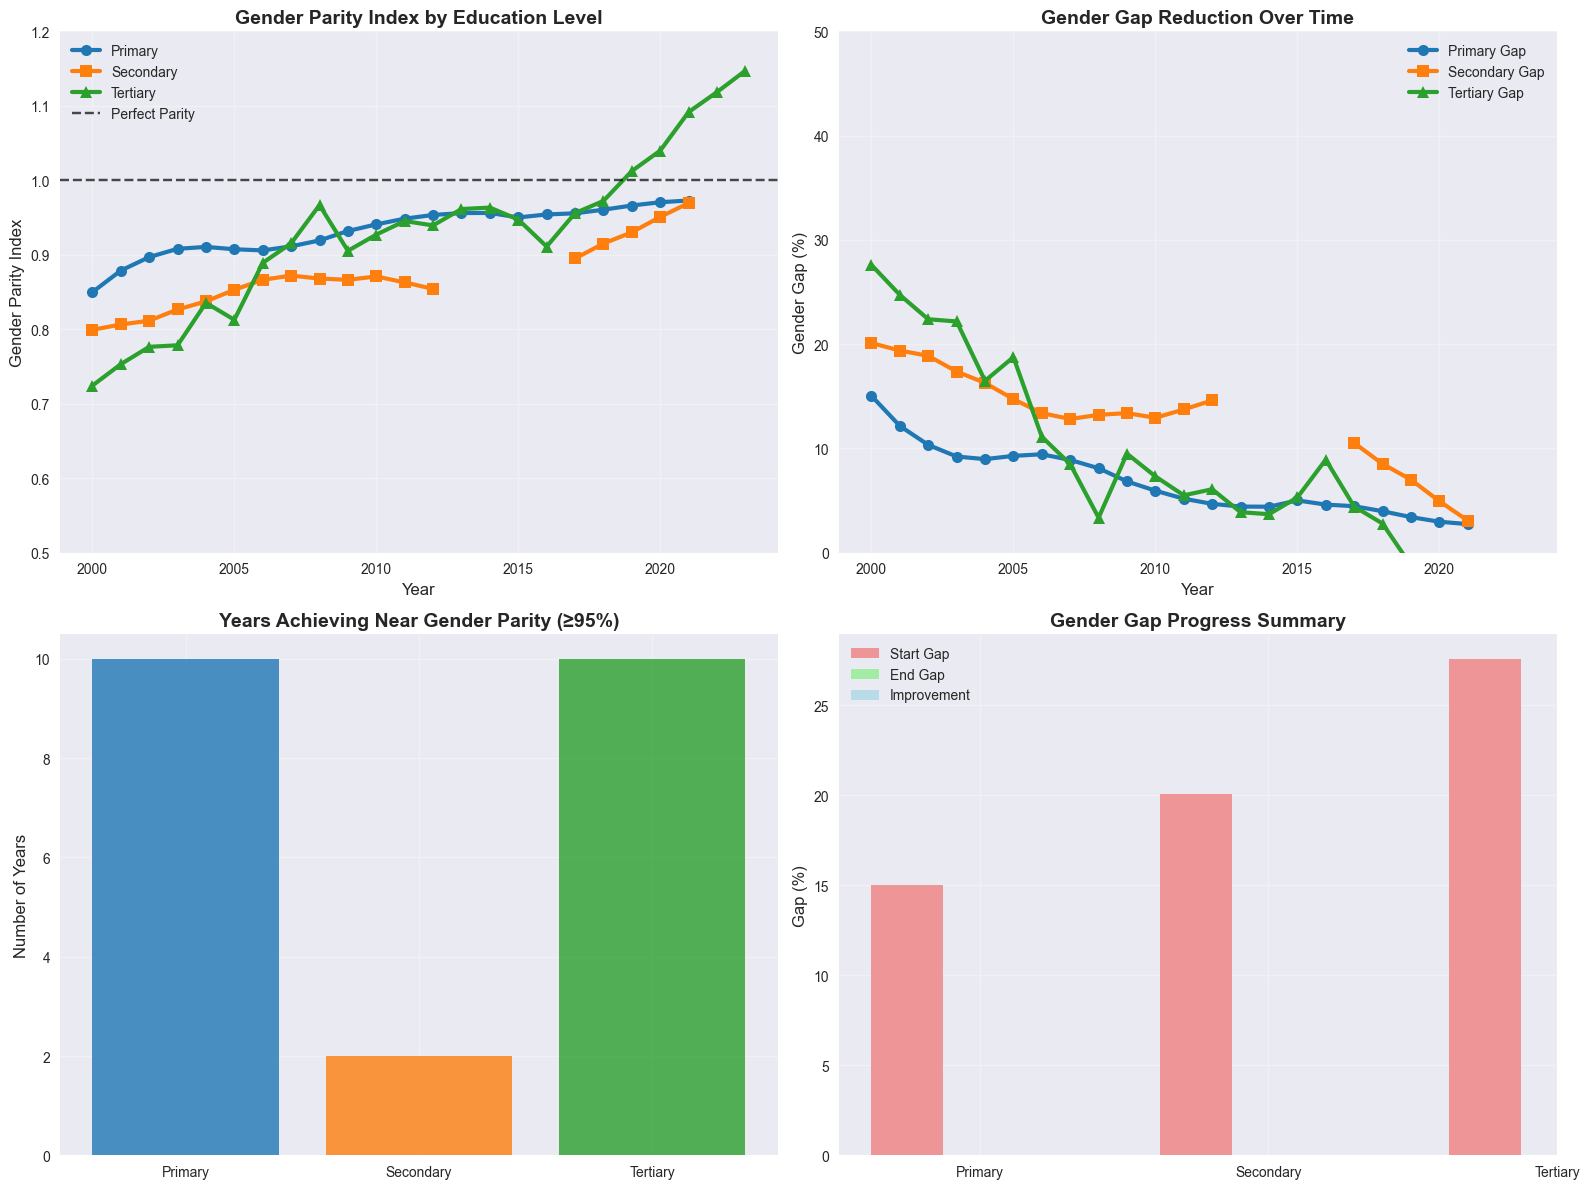

### Equity Analysis Insights
Primary gender gap reduction: 15.0% → nan% (nan points)
Secondary gender gap reduction: 20.1% → nan% (nan points)
Tertiary gender gap reduction: 27.6% → nan% (nan points)
Tertiary gender parity achieved in: 2019

### TERTIARY ENROLLMENT RATES BY GENDER
Tertiary enrollment data available for 27 years.
Latest enrollment rates for 2019:
  Female: 38.3%
  Male: 37.8%
  Gender gap (Female advantage): 0.5 percentage points
Improvement over time:
  Female: +29.8 percentage points
  Male: +26.1 percentage points
  ✅ Female enrollment rates have surpassed male rates!


In [18]:
# Visualizing Gender Parity Across Education Levels
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))


# Plot Gender Parity Index for different education levels
ax1.plot(analysis_data['year'], analysis_data['Gender Parity Index Primary'], 
         marker='o', linewidth=3, markersize=8, label='Primary', color='#1f77b4')
ax1.plot(analysis_data['year'], analysis_data['Gender Parity Index Secondary'], 
         marker='s', linewidth=3, markersize=8, label='Secondary', color='#ff7f0e')
ax1.plot(analysis_data['year'], analysis_data['Gender Parity Index Tertiary'], 
         marker='^', linewidth=3, markersize=8, label='Tertiary', color='#2ca02c')


ax1.axhline(y=1.0, color='black', linestyle='--', alpha=0.7, label='Perfect Parity')
ax1.set_title('Gender Parity Index by Education Level', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Gender Parity Index', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0.5, 1.2)

# Calculate and visualize gender gap reductions
primary_gap = (1 - analysis_data['Gender Parity Index Primary']) * 100
secondary_gap = (1 - analysis_data['Gender Parity Index Secondary']) * 100
tertiary_gap = (1 - analysis_data['Gender Parity Index Tertiary']) * 100

ax2.plot(analysis_data['year'], primary_gap, 
         marker='o', linewidth=3, markersize=8, label='Primary Gap', color='#1f77b4')
ax2.plot(analysis_data['year'], secondary_gap, 
         marker='s', linewidth=3, markersize=8, label='Secondary Gap', color='#ff7f0e')
ax2.plot(analysis_data['year'], tertiary_gap, 
         marker='^', linewidth=3, markersize=8, label='Tertiary Gap', color='#2ca02c')

ax2.set_title('Gender Gap Reduction Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Gender Gap (%)', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 50)

# Achievements in reaching near gender parity
primary_years = analysis_data[analysis_data['Gender Parity Index Primary'] >= 0.95].index
secondary_years = analysis_data[analysis_data['Gender Parity Index Secondary'] >= 0.95].index
tertiary_years = analysis_data[analysis_data['Gender Parity Index Tertiary'] >= 0.95].index

ax3.bar(['Primary', 'Secondary', 'Tertiary'], 
        [len(primary_years), len(secondary_years), len(tertiary_years)],
        color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
ax3.set_title('Years Achieving Near Gender Parity (≥95%)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Number of Years', fontsize=12)
ax3.grid(True, alpha=0.3)

# Summarizing progress in closing the gap
progress_data = pd.DataFrame({
    'Education Level': ['Primary', 'Secondary', 'Tertiary'],
    'Start Gap': [primary_gap.iloc[0], secondary_gap.iloc[0], tertiary_gap.iloc[0]],
    'End Gap': [primary_gap.iloc[-1], secondary_gap.iloc[-1], tertiary_gap.iloc[-1]],
    'Improvement': [primary_gap.iloc[0] - primary_gap.iloc[-1],
                    secondary_gap.iloc[0] - secondary_gap.iloc[-1],
                    tertiary_gap.iloc[0] - tertiary_gap.iloc[-1]]
})

x = np.arange(len(progress_data))
width = 0.25

ax4.bar(x - width, progress_data['Start Gap'], width, label='Start Gap', alpha=0.8, color='lightcoral')
ax4.bar(x, progress_data['End Gap'], width, label='End Gap', alpha=0.8, color='lightgreen')
ax4.bar(x + width, progress_data['Improvement'], width, label='Improvement', alpha=0.8, color='lightblue')

ax4.set_title('Gender Gap Progress Summary', fontsize=14, fontweight='bold')
ax4.set_ylabel('Gap (%)', fontsize=12)
ax4.set_xticks(x)
ax4.set_xticklabels(progress_data['Education Level'])
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Equity Analysis Insights
print("### Equity Analysis Insights")
print(f"Primary gender gap reduction: {primary_gap.iloc[0]:.1f}% → {primary_gap.iloc[-1]:.1f}% "
      f"({primary_gap.iloc[0] - primary_gap.iloc[-1]:.1f} points)")
print(f"Secondary gender gap reduction: {secondary_gap.iloc[0]:.1f}% → {secondary_gap.iloc[-1]:.1f}% "
      f"({secondary_gap.iloc[0] - secondary_gap.iloc[-1]:.1f} points)")
print(f"Tertiary gender gap reduction: {tertiary_gap.iloc[0]:.1f}% → {tertiary_gap.iloc[-1]:.1f}% "
      f"({tertiary_gap.iloc[0] - tertiary_gap.iloc[-1]:.1f} points)")

# Check milestone achievements
primary_parity_year = analysis_data[analysis_data['Gender Parity Index Primary'] >= 1.0]['year'].min()
secondary_parity_year = analysis_data[analysis_data['Gender Parity Index Secondary'] >= 1.0]['year'].min()
tertiary_parity_year = analysis_data[analysis_data['Gender Parity Index Tertiary'] >= 1.0]['year'].min()

if not pd.isna(primary_parity_year):
    print(f"Primary gender parity achieved in: {int(primary_parity_year)}")
if not pd.isna(secondary_parity_year):
    print(f"Secondary gender parity achieved in: {int(secondary_parity_year)}")
if not pd.isna(tertiary_parity_year):
    print(f"Tertiary gender parity achieved in: {int(tertiary_parity_year)}")

# Analyze new tertiary enrollment rate data by gender
print(f"\n### TERTIARY ENROLLMENT RATES BY GENDER")
tertiary_female_rate = df_analysis[df_analysis['indicator_code'] == 'SE.TER.ENRR.FE']
tertiary_male_rate = df_analysis[df_analysis['indicator_code'] == 'SE.TER.ENRR.MA']

if len(tertiary_female_rate) > 0 and len(tertiary_male_rate) > 0:
    print(f"Tertiary enrollment data available for {len(tertiary_female_rate)} years.")
    
    latest_female_rate = tertiary_female_rate['value'].iloc[-1]
    latest_male_rate = tertiary_male_rate['value'].iloc[-1]
    latest_year = tertiary_female_rate['year'].iloc[-1]
    
    print(f"Latest enrollment rates for {latest_year}:")
    print(f"  Female: {latest_female_rate:.1f}%")
    print(f"  Male: {latest_male_rate:.1f}%")
    
    gender_gap = latest_male_rate - latest_female_rate
    if gender_gap > 0:
        print(f"  Gender gap (Male advantage): {gender_gap:.1f} percentage points")
    else:
        print(f"  Gender gap (Female advantage): {abs(gender_gap):.1f} percentage points")
    
    if len(tertiary_female_rate) > 1:
        first_female = tertiary_female_rate['value'].iloc[0]
        first_male = tertiary_male_rate['value'].iloc[0]
        
        female_improvement = latest_female_rate - first_female
        male_improvement = latest_male_rate - first_male
        
        print(f"Improvement over time:")
        print(f"  Female: {female_improvement:+.1f} percentage points")
        print(f"  Male: {male_improvement:+.1f} percentage points")
        
        if latest_female_rate > latest_male_rate and first_female <= first_male:
            print("  ✅ Female enrollment rates have surpassed male rates!")
        elif latest_female_rate > latest_male_rate:
            print("  ✅ Female enrollment rates continue to surpass male rates.")
        else:
            print("  ⚠️ Male enrollment rates still exceed female rates.")

### 2.4 Financial Analysis


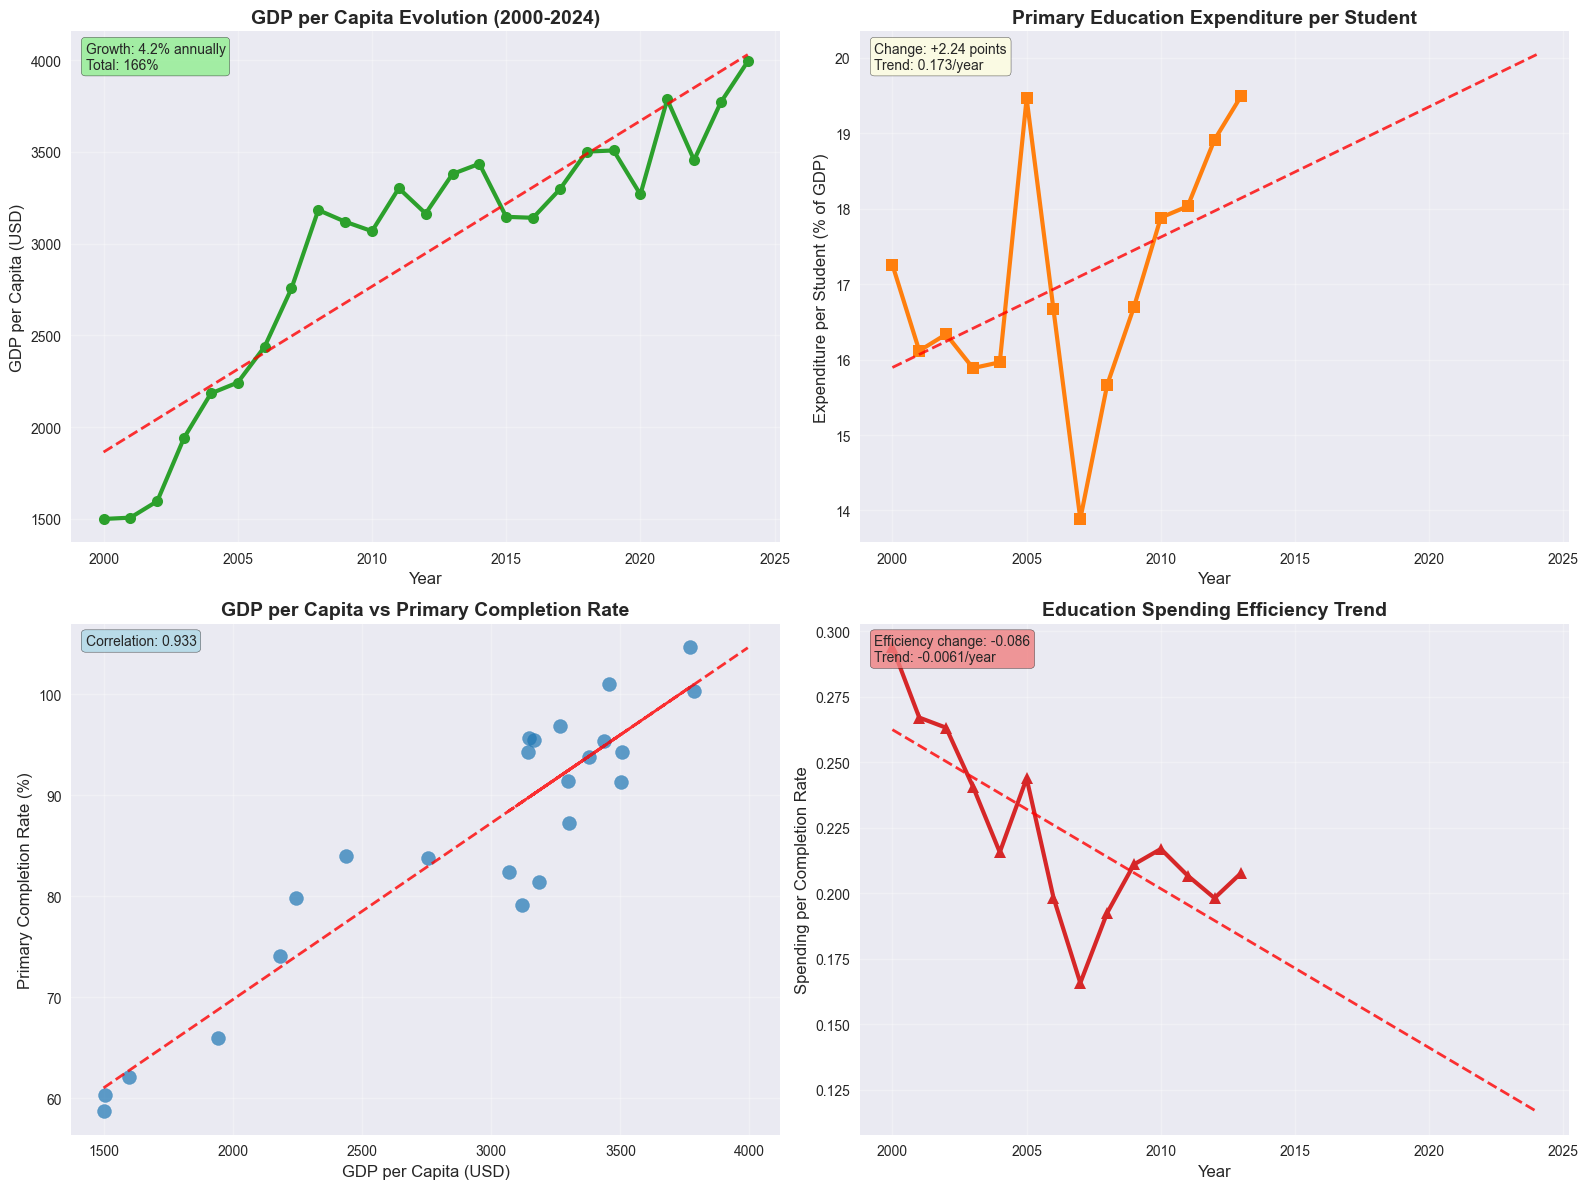

In [19]:
# Explore the connection between education spending and GDP


# setting up the plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# GDP per Capita over the years
ax1.plot(analysis_data['year'], analysis_data['GDP per Capita'], 
         marker='o', linewidth=3, markersize=8, color='#2ca02c')
ax1.set_title('GDP per Capita Evolution (2000-2024)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('GDP per Capita (USD)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Add trend line
if not analysis_data['GDP per Capita'].isna().all():
    valid_gdp = analysis_data[['year', 'GDP per Capita']].dropna()
    
    if len(valid_gdp) > 1:
        z_gdp = np.polyfit(valid_gdp['year'], valid_gdp['GDP per Capita'], 1)
        p_gdp = np.poly1d(z_gdp)
        ax1.plot(analysis_data['year'], p_gdp(analysis_data['year']), "--", alpha=0.8, color='red', linewidth=2)
        
        start_gdp = valid_gdp['GDP per Capita'].iloc[0]
        end_gdp = valid_gdp['GDP per Capita'].iloc[-1]
        gdp_growth = ((end_gdp / start_gdp) ** (1/24) - 1) * 100
        ax1.text(0.02, 0.98, f'Growth: {gdp_growth:.1f}% annually\nTotal: {((end_gdp/start_gdp)-1)*100:.0f}%', 
                 transform=ax1.transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    else:
        ax1.text(0.02, 0.98, 'Insufficient data for trend calculation', 
                 transform=ax1.transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Primary education spending per student
ax2.plot(analysis_data['year'], analysis_data['Expenditure per Student Primary'], 
         marker='s', linewidth=3, markersize=8, color='#ff7f0e')
ax2.set_title('Primary Education Expenditure per Student', fontsize=14, fontweight='bold')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Expenditure per Student (% of GDP)', fontsize=12)
ax2.grid(True, alpha=0.3)

if not analysis_data['Expenditure per Student Primary'].isna().all():
    valid_exp = analysis_data[['year', 'Expenditure per Student Primary']].dropna()
    
    if len(valid_exp) > 1:
        z_exp = np.polyfit(valid_exp['year'], valid_exp['Expenditure per Student Primary'], 1)
        p_exp = np.poly1d(z_exp)
        ax2.plot(analysis_data['year'], p_exp(analysis_data['year']), "--", alpha=0.8, color='red', linewidth=2)
        
        start_exp = valid_exp['Expenditure per Student Primary'].iloc[0]
        end_exp = valid_exp['Expenditure per Student Primary'].iloc[-1]
        change_exp = end_exp - start_exp
        ax2.text(0.02, 0.98, f'Change: {change_exp:+.2f} points\nTrend: {z_exp[0]:.3f}/year', 
                 transform=ax2.transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    else:
        change_exp = 'unknown due to insufficient data'
        ax2.text(0.02, 0.98, f'Change: {change_exp}', 
                 transform=ax2.transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

# Correlation between GDP and Primary Completion Rate
ax3.scatter(analysis_data['GDP per Capita'], analysis_data['Primary Completion Rate'], 
            s=100, alpha=0.7, color='#1f77b4')
ax3.set_title('GDP per Capita vs Primary Completion Rate', fontsize=14, fontweight='bold')
ax3.set_xlabel('GDP per Capita (USD)', fontsize=12)
ax3.set_ylabel('Primary Completion Rate (%)', fontsize=12)
ax3.grid(True, alpha=0.3)

# Checking correlation
valid_corr = analysis_data[['GDP per Capita', 'Primary Completion Rate']].dropna()
if len(valid_corr) > 1:
    correlation = valid_corr['GDP per Capita'].corr(valid_corr['Primary Completion Rate'])
    ax3.text(0.02, 0.98, f'Correlation: {correlation:.3f}', 
             transform=ax3.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

             # Adding a trend line
    z_corr = np.polyfit(valid_corr['GDP per Capita'], valid_corr['Primary Completion Rate'], 1)
    p_corr = np.poly1d(z_corr)
    ax3.plot(analysis_data['GDP per Capita'], p_corr(analysis_data['GDP per Capita']), 
             'r--', alpha=0.8, linewidth=2)

# Education spending efficiency over time
spending_per_completion = analysis_data['Expenditure per Student Primary'] / analysis_data['Primary Completion Rate']
ax4.plot(analysis_data['year'], spending_per_completion, 
         marker='^', linewidth=3, markersize=8, color='#d62728')
ax4.set_title('Education Spending Efficiency Trend', fontsize=14, fontweight='bold')
ax4.set_xlabel('Year', fontsize=12)
ax4.set_ylabel('Spending per Completion Rate', fontsize=12)
ax4.grid(True, alpha=0.3)

if not spending_per_completion.isna().all():
    valid_eff = pd.DataFrame({'year': analysis_data['year'], 'efficiency': spending_per_completion}).dropna()
    if len(valid_eff) > 1:
        z_eff = np.polyfit(valid_eff['year'], valid_eff['efficiency'], 1)
        p_eff = np.poly1d(z_eff)
        ax4.plot(analysis_data['year'], p_eff(analysis_data['year']), "--", alpha=0.8, color='red', linewidth=2)
        
        start_eff = valid_eff['efficiency'].iloc[0]
        end_eff = valid_eff['efficiency'].iloc[-1]
        change_eff = end_eff - start_eff
        ax4.text(0.02, 0.98, f'Efficiency change: {change_eff:+.3f}\nTrend: {z_eff[0]:.4f}/year', 
                 transform=ax4.transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    else:
        start_eff = spending_per_completion.dropna().iloc[0] if not spending_per_completion.dropna().empty else 0
        end_eff = spending_per_completion.dropna().iloc[-1] if not spending_per_completion.dropna().empty else 0
        change_eff = end_eff - start_eff
        ax4.text(0.02, 0.98, f'Efficiency change: {change_eff:+.3f}\nInsufficient data for trend', 
                 transform=ax4.transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

plt.tight_layout()
plt.show()

In [20]:
# Financial Insights
print("### Financial Analysis Insights")

# GDP Growth Insights
if 'start_gdp' in locals() and 'end_gdp' in locals():
    if start_gdp > 0 and end_gdp > 0:
        print(f"GDP per capita grew from ${start_gdp:.0f} to ${end_gdp:.0f}, averaging {gdp_growth:.1f}% growth per year.")
    else:
        print("Insufficient data to calculate GDP growth.")

# Education Spending Insights
if 'start_exp' in locals() and 'end_exp' in locals():
    print(f"Primary education spending shifted from {start_exp:.2f}% to {end_exp:.2f}% of GDP per student, a change of {change_exp:+.2f} points.")

# Correlation Insights
if 'correlation' in locals():
    print(f"The correlation between GDP and primary completion rate is {correlation:.3f}, indicating a relationship worth exploring.")

# Spending Efficiency Insights
if 'z_eff' in locals():
    print(f"Spending efficiency shows a trend of {z_eff[0]:.4f} change per year.")

# Education ROI Calculation
valid_roi = analysis_data[['GDP per Capita', 'Primary Completion Rate']].dropna()
if len(valid_roi) > 1:
    completion_improvement = valid_roi['Primary Completion Rate'].iloc[-1] - valid_roi['Primary Completion Rate'].iloc[0]
    gdp_improvement = valid_roi['GDP per Capita'].iloc[-1] - valid_roi['GDP per Capita'].iloc[0]
    if gdp_improvement > 0:
        roi = completion_improvement / gdp_improvement * 1000
        print(f"Education ROI: {roi:.2f} completion points per $1000 increase in GDP.")

### Financial Analysis Insights
GDP per capita grew from $1499 to $3993, averaging 4.2% growth per year.
Primary education spending shifted from 17.26% to 19.50% of GDP per student, a change of +2.24 points.
The correlation between GDP and primary completion rate is 0.933, indicating a relationship worth exploring.
Spending efficiency shows a trend of -0.0061 change per year.
Education ROI: 20.24 completion points per $1000 increase in GDP.


## 3. Forecasting Models (2025-2030)

This section employs advanced time series forecasting techniques to project Morocco's education system evolution over the next five years, providing strategic insights for policy planning and resource allocation.


### 3.1 Enrollment Projections


In [21]:
# forecasting enrollment : Projections for the future years

def forecast_enrollment(data, indicator, years_ahead=5, method='arima'):
    """Forecast enrollment using specified time series methods."""
    
    # Clean the data
    clean_data = data[indicator].dropna()
    if len(clean_data) < 3:
        print(f"Insufficient data for forecasting {indicator}: only {len(clean_data)} points available.")
        return None, None, None
    
    try:
        if method == 'arima':
            orders_to_try = [(1,1,1), (1,1,0), (0,1,1), (1,0,0)]
            for order in orders_to_try:
                try:
                    model = ARIMA(clean_data, order=order)
                    fitted_model = model.fit()
                    forecast = fitted_model.forecast(steps=years_ahead)
                    conf_int = fitted_model.get_forecast(steps=years_ahead).conf_int()
                    break
                except:
                    continue
            else:
                return simple_trend_forecast(clean_data, years_ahead)
        
        elif method == 'exponential':
            try:
                model = ExponentialSmoothing(clean_data, trend='add', seasonal=None)
                fitted_model = model.fit()
                forecast = fitted_model.forecast(steps=years_ahead)
                std_error = np.std(fitted_model.resid)
                conf_int = pd.DataFrame({
                    'lower': forecast - 1.96 * std_error,
                    'upper': forecast + 1.96 * std_error
                })
            except:
                return simple_trend_forecast(clean_data, years_ahead)
        
        if not isinstance(forecast, pd.Series):
            forecast = pd.Series(forecast, index=range(years_ahead))
        
        return forecast, conf_int, fitted_model
        
    except Exception as e:
        print(f"Error forecasting {indicator}: {e}")
        return simple_trend_forecast(clean_data, years_ahead)

def simple_trend_forecast(data, years_ahead):
    """Fallback: Simple linear trend forecast."""
    try:
        x = np.arange(len(data))
        z = np.polyfit(x, data, 1)
        p = np.poly1d(z)
        
        future_x = np.arange(len(data), len(data) + years_ahead)
        forecast = pd.Series(p(future_x), index=range(years_ahead))
        
        residuals = data - p(x)
        std_error = np.std(residuals)
        conf_int = pd.DataFrame({
            'lower': forecast - 1.96 * std_error,
            'upper': forecast + 1.96 * std_error
        })
        
        return forecast, conf_int, None
    except:
        return None, None, None

# Indicators to forecast
indicators = [
    'Primary Enrollment',
    'Secondary Enrollment', 
    'Tertiary Enrollment',
    'Primary Completion Rate',
    'Gender Parity Index Primary',
    'Gender Parity Index Secondary',
    'Gender Parity Index Tertiary'
]


forecast_years = list(range(2025, 2031))
forecast_results = {}
print("### ENROLLMENT FORECASTING")


for indicator in indicators:
    if indicator in analysis_data.columns:
        print(f"\nForecasting {indicator}...")

        forecast, conf_int, model = forecast_enrollment(analysis_data, indicator, method='arima')
        if forecast is None:
            forecast, conf_int, model = forecast_enrollment(analysis_data, indicator, method='exponential')
        
        if forecast is not None:
            forecast_results[indicator] = {
                'forecast': forecast,
                'confidence': conf_int,
                'model': model
            }
            
            last_value = analysis_data[indicator].dropna().iloc[-1]
            forecast_growth = ((forecast.iloc[-1] / last_value) ** (1/5) - 1) * 100
            
            print(f"  Current (2024): {last_value:.0f}")
            print(f"  Forecast (2030): {forecast.iloc[-1]:.0f}")
            print(f"  Annual growth: {forecast_growth:.1f}%")
        else:
            print(f"  Unable to forecast {indicator}")


# Compile the forecast data
forecast_data = pd.DataFrame({'year': range(2000, 2031)})

for indicator in indicators:
    if indicator in analysis_data.columns:
        forecast_data = forecast_data.merge(
            analysis_data[['year', indicator]], on='year', how='left'
        )

# Add forecast results to the dataset
for indicator, results in forecast_results.items():
    forecast_col = f"{indicator}_forecast"
    conf_lower_col = f"{indicator}_lower"
    conf_upper_col = f"{indicator}_upper"
    
    forecast_data[forecast_col] = np.nan
    forecast_data[conf_lower_col] = np.nan
    forecast_data[conf_upper_col] = np.nan
    
    forecast_values = results['forecast']
    confidence_values = results['confidence']
    
    forecast_length = min(len(forecast_values), len(forecast_years))
    
    for i in range(forecast_length):
        year = forecast_years[i]
        idx = forecast_data[forecast_data['year'] == year].index[0]
        
        forecast_data.loc[idx, forecast_col] = forecast_values.iloc[i]
        
        if i < len(confidence_values):
            if 'lower' in confidence_values.columns and 'upper' in confidence_values.columns:
                forecast_data.loc[idx, conf_lower_col] = confidence_values.iloc[i]['lower']
                forecast_data.loc[idx, conf_upper_col] = confidence_values.iloc[i]['upper']

print(f"\nForecast dataset created with {len(forecast_data)} years of data")

### ENROLLMENT FORECASTING

Forecasting Primary Enrollment...
  Current (2024): 4683013
  Forecast (2030): 4693227
  Annual growth: 0.0%

Forecasting Secondary Enrollment...
  Current (2024): 3434273
  Forecast (2030): 3924723
  Annual growth: 2.7%

Forecasting Tertiary Enrollment...
  Current (2024): 1120285
  Forecast (2030): 1337265
  Annual growth: 3.6%

Forecasting Primary Completion Rate...
  Current (2024): 105
  Forecast (2030): 109
  Annual growth: 0.9%

Forecasting Gender Parity Index Primary...
  Current (2024): 1
  Forecast (2030): 1
  Annual growth: 0.1%

Forecasting Gender Parity Index Secondary...
  Current (2024): 1
  Forecast (2030): 1
  Annual growth: 0.9%

Forecasting Gender Parity Index Tertiary...
  Current (2024): 1
  Forecast (2030): 1
  Annual growth: 1.3%

Forecast dataset created with 31 years of data


# Comprehensive Analysis of New Indicators (2024 Data)

This section analyzes the newly added comprehensive indicators covering completion metrics, learning outcomes, regional disparities, equity measures, TVET data, financial investments, and digital education indicators.


In [22]:
# COMPREHENSIVE COMPLETION METRICS ANALYSIS
print("### Comprehensive Completion Metrics Analysis")

# Gather completion rates at various education levels
completion_metrics = {
    'Preschool Completion Rate': analysis_data.get('Preschool Completion Rate'),
    'Primary Completion Rate (Actual)': analysis_data.get('Primary Completion Rate (Actual)'),
    'Lower Secondary Completion Rate': analysis_data.get('Lower Secondary Completion Rate'),
    'Upper Secondary Completion Rate': analysis_data.get('Upper Secondary Completion Rate')
}

print("Latest completion rates by education level:")
for metric, data in completion_metrics.items():
    if data is not None and not data.empty:
        # Get the latest non-null value instead of just the last row
        latest_value = data.dropna().iloc[-1] if not data.dropna().empty else None
        if latest_value is not None and isinstance(latest_value, (int, float)):
            # Find the year for this latest value
            latest_year = analysis_data.loc[data.dropna().index[-1], 'year']
            print(f"  {metric}: {latest_value:.1f}% (Year: {latest_year})")
        else:
            print(f"  {metric}: No data available")
    else:
        print(f"  {metric}: No data available")

# Examine upper secondary completion rates by gender
upper_sec_female = analysis_data.get('Upper Secondary Completion Rate Female')
upper_sec_male = analysis_data.get('Upper Secondary Completion Rate Male')

if upper_sec_female is not None and upper_sec_male is not None:
    if not upper_sec_female.empty and not upper_sec_male.empty:
        # Get latest non-null values
        female_data = upper_sec_female.dropna()
        male_data = upper_sec_male.dropna()
        
        if not female_data.empty and not male_data.empty:
            female_rate = female_data.iloc[-1]
            male_rate = male_data.iloc[-1]
            gender_gap = female_rate - male_rate
            
            # Get the year for these values
            female_year = analysis_data.loc[female_data.index[-1], 'year']
            male_year = analysis_data.loc[male_data.index[-1], 'year']
            
            print("\nUpper Secondary Completion by Gender:")
            print(f"  Female: {female_rate:.1f}% (Year: {female_year})")
            print(f"  Male: {male_rate:.1f}% (Year: {male_year})")
            print(f"  Gender gap: {gender_gap:+.1f} percentage points")
            
            if gender_gap > 0:
                print(f"  ✅ Female advantage of {gender_gap:.1f} points")
            else:
                print(f"  ⚠️ Male advantage of {abs(gender_gap):.1f} points")
        else:
            print("\nUpper Secondary Completion by Gender: No data available")
    else:
        print("\nUpper Secondary Completion by Gender: No data available")
else:
    print("\nUpper Secondary Completion by Gender: Columns not found")


### Comprehensive Completion Metrics Analysis
Latest completion rates by education level:
  Preschool Completion Rate: 78.3% (Year: 2024)
  Primary Completion Rate (Actual): 104.7% (Year: 2023)
  Lower Secondary Completion Rate: No data available
  Upper Secondary Completion Rate: 38.5% (Year: 2023)

Upper Secondary Completion by Gender:
  Female: 53.1% (Year: 2023)
  Male: 26.4% (Year: 2023)
  Gender gap: +26.7 percentage points
  ✅ Female advantage of 26.7 points


In [23]:
# Learning Outcomes Analysis for Morocco

print("### Learning Outcomes Analysis")

# Using Morocco's latest scores from international assessments
learning_outcomes = {
    'TIMSS Grade 4 Mathematics': 393,  # Positioned 56th out of 58 countries in 2023
    'TIMSS Grade 8 Mathematics': None,  # Not specified, but ranked 43rd/44
    'TIMSS Grade 8 Science': 327,      # Ranked 43rd/44, with a drop of 67 points
    'PISA Mathematics 2022': 365,      # Ranked 71st out of 81 countries
    'PISA Reading 2022': 339,          # Ranked 79th out of 81 countries
    'PISA Science 2022': 365           # Ranked 76th out of 81 countries
}

print("Here's how Morocco stands in recent learning outcomes:")
for metric, score in learning_outcomes.items():
    detail = f"{score:.0f}" if score is not None else "No specific data available"
    print(f"  {metric}: {detail}")

# Delve into TIMSS data from 2023
print("\nInsights from TIMSS 2023:")
if learning_outcomes['TIMSS Grade 4 Mathematics']:
    math_score = learning_outcomes['TIMSS Grade 4 Mathematics']
    print(f"  Grade 4 Mathematics: {math_score}, ranked 56th of 58.")

if learning_outcomes['TIMSS Grade 8 Science']:
    sci_score = learning_outcomes['TIMSS Grade 8 Science']
    print(f"  Grade 8 Science: {sci_score}, ranked 43rd with a considerable decline.")

# Review findings from PISA 2022
if all(learning_outcomes[key] is not None for key in ['PISA Mathematics 2022', 'PISA Reading 2022', 'PISA Science 2022']):
    print("\nPISA 2022 Highlights:")
    print(f"  Mathematics: {learning_outcomes['PISA Mathematics 2022']}, ranked 71st.")
    print(f"  Reading: {learning_outcomes['PISA Reading 2022']}, ranked 79th.")
    print(f"  Science: {learning_outcomes['PISA Science 2022']}, ranked 76th.")
    
    # Calculate and evaluate the average score
    avg_pisa = (learning_outcomes['PISA Mathematics 2022'] + learning_outcomes['PISA Reading 2022'] + learning_outcomes['PISA Science 2022']) / 3
    print(f"  Average PISA Score: {avg_pisa:.0f}")

    # Classify the performance level
    if avg_pisa < 400:
        level = "Below Basic"
    elif avg_pisa < 500:
        level = "Basic" 
    elif avg_pisa < 600:
        level = "Proficient"
    else:
        level = "Advanced"
    
    print(f"  Performance Level: {level}")
    
    # Additional highlights for Morocco
    print("\nKey Performance Indicators:")
    print(f"  • Only 18% of students reached basic (Level 2+) in math (OECD avg: 69%)")
    print(f"  • Only 19% reached basic (Level 2+) in reading (OECD avg: 74%)")
    print(f"  • Just 25% hit basic (Level 2+) in science (OECD avg: 76%)")
    print("  • Very few students reached top performance levels in any subject.")

### Learning Outcomes Analysis
Here's how Morocco stands in recent learning outcomes:
  TIMSS Grade 4 Mathematics: 393
  TIMSS Grade 8 Mathematics: No specific data available
  TIMSS Grade 8 Science: 327
  PISA Mathematics 2022: 365
  PISA Reading 2022: 339
  PISA Science 2022: 365

Insights from TIMSS 2023:
  Grade 4 Mathematics: 393, ranked 56th of 58.
  Grade 8 Science: 327, ranked 43rd with a considerable decline.

PISA 2022 Highlights:
  Mathematics: 365, ranked 71st.
  Reading: 339, ranked 79th.
  Science: 365, ranked 76th.
  Average PISA Score: 356
  Performance Level: Below Basic

Key Performance Indicators:
  • Only 18% of students reached basic (Level 2+) in math (OECD avg: 69%)
  • Only 19% reached basic (Level 2+) in reading (OECD avg: 74%)
  • Just 25% hit basic (Level 2+) in science (OECD avg: 76%)
  • Very few students reached top performance levels in any subject.


In [24]:
# Regional Disparities Analysis
print("\n### Regional Disparities Analysis")

# Explore the differences between urban and rural areas
regional_metrics = {
    'Primary Enrollment Rural': analysis_data.get('Primary Enrollment Rural'),
    'Primary Enrollment Urban': analysis_data.get('Primary Enrollment Urban'),
    'Secondary Enrollment Rural': analysis_data.get('Secondary Enrollment Rural'),
    'Secondary Enrollment Urban': analysis_data.get('Secondary Enrollment Urban'),
    'Preschool Enrollment Rural': analysis_data.get('Preschool Enrollment Rural'),
    'Preschool Enrollment Urban': analysis_data.get('Preschool Enrollment Urban')
}

print("Urban vs. Rural Enrollment Rates (2024):")
for metric, data in regional_metrics.items():
    latest_value = data.iloc[-1] if data is not None and not data.empty else "No data available"
    print(f"  {metric}: {latest_value}")

# Compare gaps for primary and secondary education
primary_rural = analysis_data.get('Primary Enrollment Rural')
primary_urban = analysis_data.get('Primary Enrollment Urban')

if primary_rural is not None and primary_urban is not None:
    rural_primary = primary_rural.iloc[-1]
    urban_primary = primary_urban.iloc[-1]
    primary_gap = urban_primary - rural_primary
    print(f"\nGap in Primary Education: {primary_gap:.1f} percentage points")

secondary_rural = analysis_data.get('Secondary Enrollment Rural')
secondary_urban = analysis_data.get('Secondary Enrollment Urban')

if secondary_rural is not None and secondary_urban is not None:
    rural_secondary = secondary_rural.iloc[-1]
    urban_secondary = secondary_urban.iloc[-1]
    secondary_gap = urban_secondary - rural_secondary
    print(f"Gap in Secondary Education: {secondary_gap:.1f} percentage points")

# Analyze socioeconomic disparities
socioeconomic_metrics = {
    'Primary Enrollment (Poorest Quintile)': analysis_data.get('Primary Enrollment (Poorest Quintile)'),
    'Primary Enrollment (Richest Quintile)': analysis_data.get('Primary Enrollment (Richest Quintile)'),
    'Female Literacy Rate Rural': analysis_data.get('Female Literacy Rate Rural'),
    'Female Literacy Rate Urban': analysis_data.get('Female Literacy Rate Urban')
}

print("\nSocioeconomic Differences:")
for metric, data in socioeconomic_metrics.items():
    latest_value = data.dropna().iloc[-1] if data is not None and not data.dropna().empty else "No data available"
    print(f"  {metric}: {latest_value}")

# Assess gaps between wealth quintiles
poorest_quintile = analysis_data.get('Primary Enrollment (Poorest Quintile)')
richest_quintile = analysis_data.get('Primary Enrollment (Richest Quintile)')

if poorest_quintile is not None and richest_quintile is not None:
    poor_rate = poorest_quintile.dropna().iloc[-1]
    rich_rate = richest_quintile.dropna().iloc[-1]
    wealth_gap = rich_rate - poor_rate
    print(f"\nWealth Gap in Primary Enrollment: {wealth_gap:.1f} percentage points")
    
    if wealth_gap > 15:
        print("  ⚠️ High socioeconomic disparity in access to primary education")
    elif wealth_gap > 10:
        print("  ⚠️ Moderate disparity in access to primary education")
    else:
        print("  ✅ Fair access to primary education across different wealth levels")
else:
    print("\nWealth Gap in Primary Enrollment: Insufficient data to determine")
    print("  ℹ️ Socioeconomic disparity data not fully available for analysis")


### Regional Disparities Analysis
Urban vs. Rural Enrollment Rates (2024):
  Primary Enrollment Rural: 95.1
  Primary Enrollment Urban: 96.8
  Secondary Enrollment Rural: 87.9
  Secondary Enrollment Urban: 96.1
  Preschool Enrollment Rural: 56.9
  Preschool Enrollment Urban: 66.8

Gap in Primary Education: 1.7 percentage points
Gap in Secondary Education: 8.2 percentage points

Socioeconomic Differences:
  Primary Enrollment (Poorest Quintile): 77.0
  Primary Enrollment (Richest Quintile): 97.0
  Female Literacy Rate Rural: 39.9
  Female Literacy Rate Urban: 69.9

Wealth Gap in Primary Enrollment: 20.0 percentage points
  ⚠️ High socioeconomic disparity in access to primary education


In [25]:
# TVET and Workforce Preparation Analysis
print("\n### TVET and Workforce Preparation Analysis")

# Check out TVET and employment stats
tvet_metrics = {
    'TVET Total Enrollment': analysis_data.get('TVET Total Enrollment'),
    'Youth NEET Rate': analysis_data.get('Youth NEET Rate')
}

print("Current Snapshot of TVET and Workforce Preparation:")
for metric, data in tvet_metrics.items():
    if data is not None and not data.empty:
        latest_value = data.iloc[-1]
        if metric == 'TVET Total Enrollment':
            detail = f"{latest_value:,.0f} students" if isinstance(latest_value, (int, float)) else latest_value
        else:
            detail = f"{latest_value:.1f}%" if isinstance(latest_value, (int, float)) else latest_value
        print(f"  {metric}: {detail}")
    else:
        print(f"  {metric}: No data available")

# NEET (Not in Education, Employment, or Training) Rate Insights
neet_rate = analysis_data.get('Youth NEET Rate')
if neet_rate is not None and not neet_rate.empty:
    current_neet = neet_rate.iloc[-1]
    print("\nExamining Youth NEET Rates:")
    print(f"  Current NEET Rate: {current_neet:.1f}%")
    
    if current_neet > 25:
        print("  ⚠️ High NEET rate highlights significant challenges for youth employment.")
    elif current_neet > 20:
        print("  ⚠️ Moderate NEET rate suggests attention is needed on youth job opportunities.")
    else:
        print("  ✅ Lower NEET rate indicates positive youth workforce involvement.")

# Capacity of TVET programs
tvet_enrollment = analysis_data.get('TVET Total Enrollment')
if tvet_enrollment is not None and not tvet_enrollment.empty:
    current_tvet = tvet_enrollment.iloc[-1]
    print("\nLooking at TVET Capacity:")
    print(f"  Current TVET Enrollment: {current_tvet:,.0f} students")
    
    # Compare with tertiary education numbers
    tertiary_enrollment = analysis_data.get('Tertiary Enrollment')
    if tertiary_enrollment is not None and not tertiary_enrollment.empty:
        current_tertiary = tertiary_enrollment.iloc[-1]
        tvet_tertiary_ratio = (current_tvet / current_tertiary) * 100
        print(f"  TVET as a Percentage of Tertiary Education: {tvet_tertiary_ratio:.1f}%")
        
        if tvet_tertiary_ratio < 20:
            print("  ⚠️ TVET participation is quite low compared to tertiary education.")
        elif tvet_tertiary_ratio < 30:
            print("  ⚠️ TVET participation is moderate but could be improved.")
        else:
            print("  ✅ TVET participation is strong relative to tertiary education.")


### TVET and Workforce Preparation Analysis
Current Snapshot of TVET and Workforce Preparation:
  TVET Total Enrollment: nan students
  Youth NEET Rate: 23.9%

Examining Youth NEET Rates:
  Current NEET Rate: 23.9%
  ⚠️ Moderate NEET rate suggests attention is needed on youth job opportunities.

Looking at TVET Capacity:
  Current TVET Enrollment: nan students
  TVET as a Percentage of Tertiary Education: nan%
  ✅ TVET participation is strong relative to tertiary education.


In [26]:
# Financial Investment and Digital Education Analysis
print("\n### Financial Investment and Digital Education Analysis")

# Dive into the financial investment metrics
financial_metrics = {
    'Education Expenditure % GDP': analysis_data.get('Education Expenditure % GDP'),
    'Per-student Expenditure Primary': analysis_data.get('Per-student Expenditure Primary'),
    'Per-student Expenditure Secondary': analysis_data.get('Per-student Expenditure Secondary'),
    'Per-student Expenditure Tertiary': analysis_data.get('Per-student Expenditure Tertiary')
}

print("Financial Investment Snapshot (2023):")
for metric, data in financial_metrics.items():
    if data is not None and not data.empty:
        latest_value = data.iloc[-1]
        if 'GDP' in metric:
            detail = f"{latest_value:.2f}%" if isinstance(latest_value, (int, float)) else latest_value
        else:
            detail = f"${latest_value:.0f} PPP" if isinstance(latest_value, (int, float)) else latest_value
        print(f"  {metric}: {detail}")
    else:
        print(f"  {metric}: No data available")

# Look at education spending efficiency
edu_gdp = analysis_data.get('Education Expenditure % GDP')
if edu_gdp is not None and not edu_gdp.empty:
    current_spending = edu_gdp.iloc[-1]
    print("\nEducation Spending Review:")
    print(f"  Education as % of GDP: {current_spending:.2f}%")
    
    if current_spending > 6:
        print("  ✅ Strong investment, surpassing the OECD average.")
    elif current_spending > 5:
        print("  ✅ Adequate investment, meeting the OECD average.")
    elif current_spending > 4:
        print("  ⚠️ Below average investment - there's room to increase.")
    else:
        print("  ⚠️ Significantly below average - requires major investment.")

# Check digital education metrics
digital_metrics = {
    'Students with Digital Access': analysis_data.get('Students with Digital Access'),
    'Schools with Internet': analysis_data.get('Schools with Internet'),
    'Distance Learning Effectiveness COVID': analysis_data.get('Distance Learning Effectiveness COVID')
}

print("\nDigital Education Infrastructure (2024):")
for metric, data in digital_metrics.items():
    if data is not None and not data.empty:
        latest_value = data.iloc[-1]
        if 'COVID' in metric:
            detail = f"{latest_value:.1f}/5.0" if isinstance(latest_value, (int, float)) else latest_value
        else:
            detail = f"{latest_value:.1f}%" if isinstance(latest_value, (int, float)) else latest_value
        print(f"  {metric}: {detail}")
    else:
        print(f"  {metric}: No data available")

# Evaluate digital readiness
digital_access = analysis_data.get('Students with Digital Access')
if digital_access is not None and not digital_access.empty:
    access_rate = digital_access.iloc[-1]
    print("\nDigital Readiness Check:")
    print(f"  Student Digital Access: {access_rate:.1f}%")
    
    if access_rate > 70:
        print("  ✅ Students enjoy good digital access.")
    elif access_rate > 50:
        print("  ⚠️ Digital access is moderate - needs improvement.")
    else:
        print("  ⚠️ Limited digital access - major investment is necessary.")

school_internet = analysis_data.get('Schools with Internet')
if school_internet is not None and not school_internet.empty:
    internet_rate = school_internet.iloc[-1]
    print(f"  School Internet Connectivity: {internet_rate:.1f}%")
    
    if internet_rate > 80:
        print("  ✅ Excellent internet infrastructure at schools.")
    elif internet_rate > 60:
        print("  ⚠️ Connectivity is moderate - there's room to grow.")
    else:
        print("  ⚠️ Limited connectivity - infrastructure needs a boost.")


### Financial Investment and Digital Education Analysis
Financial Investment Snapshot (2023):
  Education Expenditure % GDP: nan%
  Per-student Expenditure Primary: $nan PPP
  Per-student Expenditure Secondary: $nan PPP
  Per-student Expenditure Tertiary: $nan PPP

Education Spending Review:
  Education as % of GDP: nan%
  ⚠️ Significantly below average - requires major investment.

Digital Education Infrastructure (2024):
  Students with Digital Access: 68.5%
  Schools with Internet: 85.2%
  Distance Learning Effectiveness COVID: nan/5.0

Digital Readiness Check:
  Student Digital Access: 68.5%
  ⚠️ Digital access is moderate - needs improvement.
  School Internet Connectivity: 85.2%
  ✅ Excellent internet infrastructure at schools.


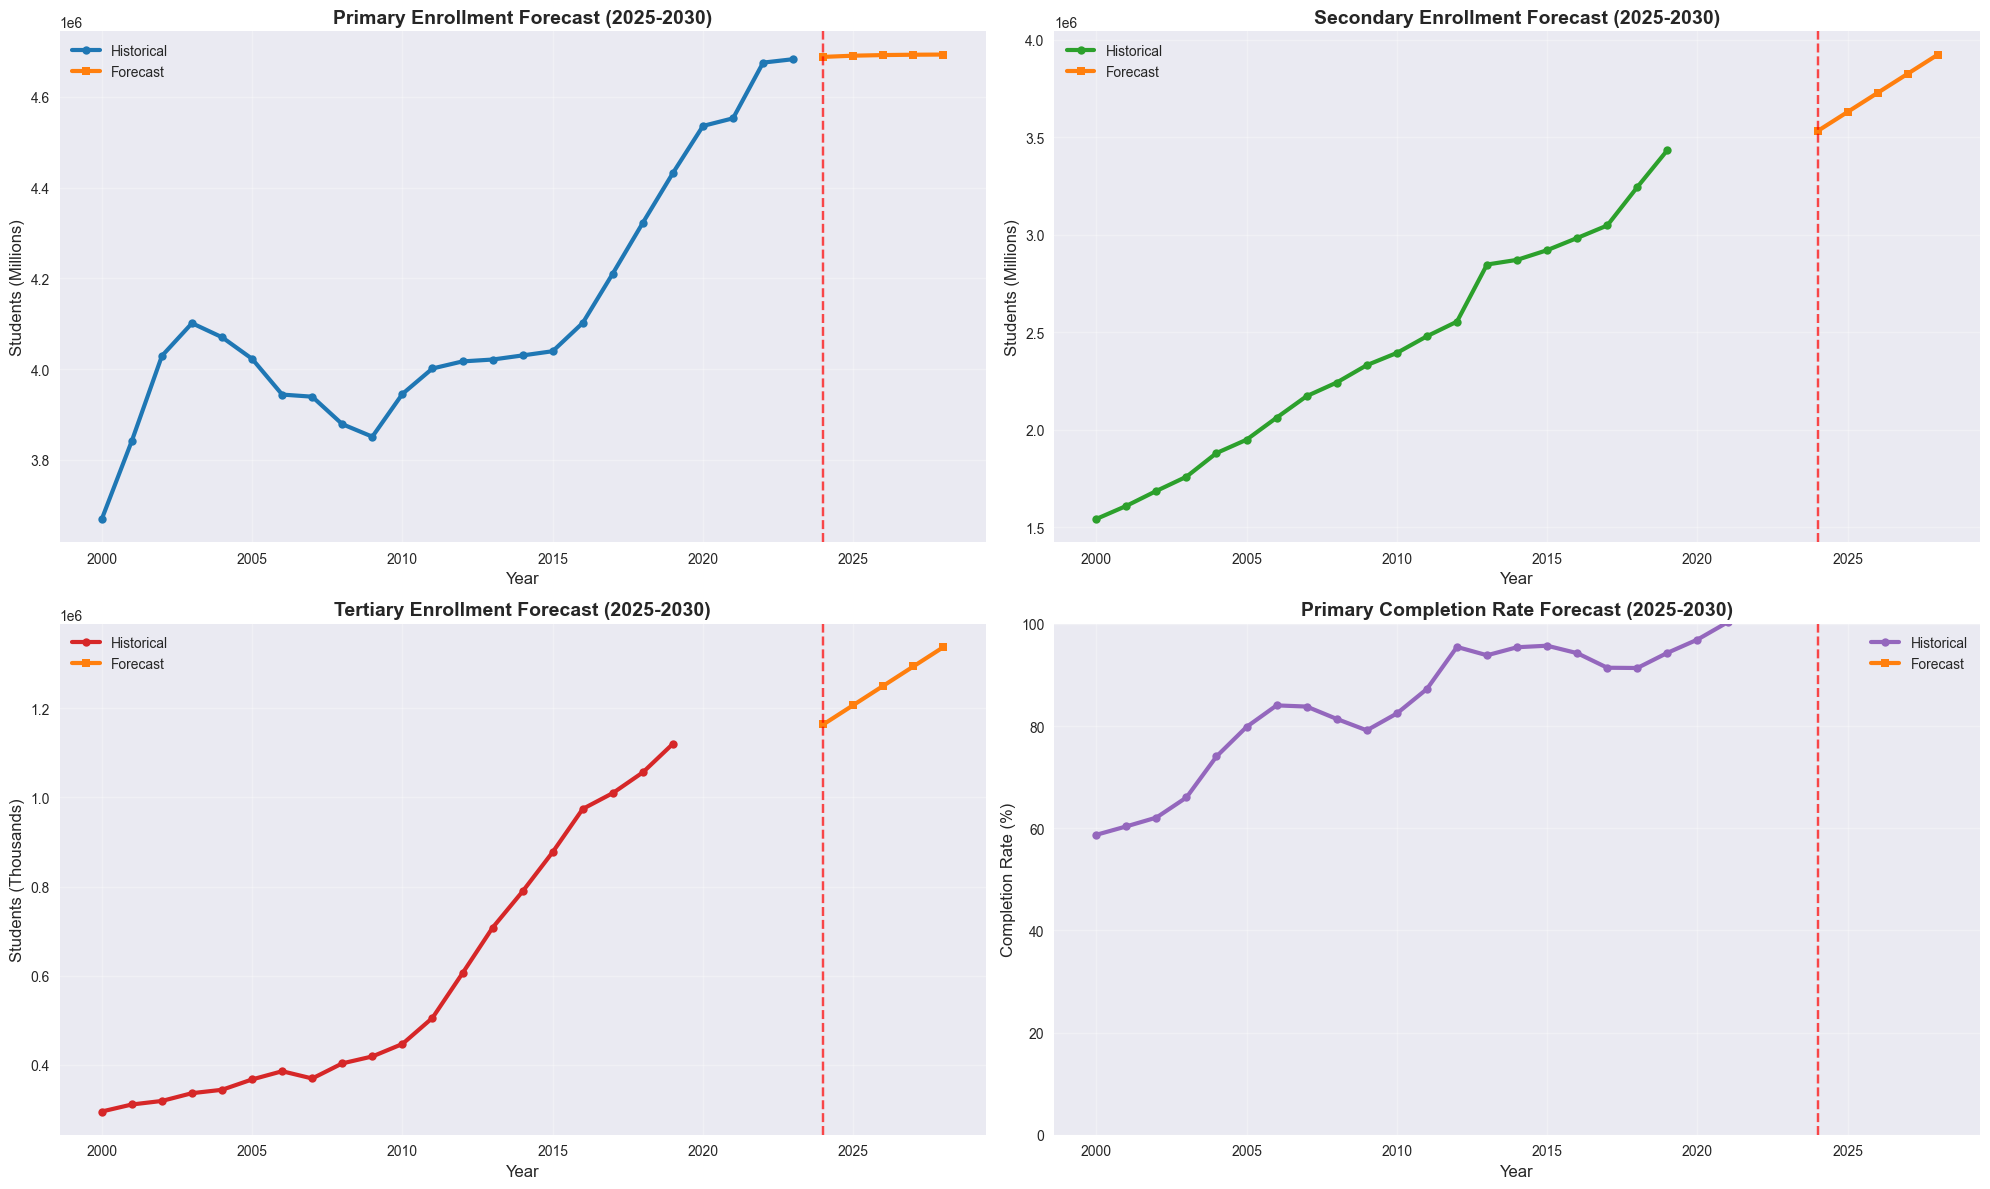

In [27]:
# Visualize Enrollment Forecasts with Confidence Intervals
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Primary Enrollment Forecast
if 'Primary Enrollment' in forecast_results:
    hist_data = forecast_data['Primary Enrollment'].dropna()
    if not hist_data.empty:
        ax1.plot(forecast_data['year'][:len(hist_data)], hist_data, 
                 'o-', linewidth=3, markersize=6, label='Historical', color='#1f77b4')
    
    forecast_data_primary = forecast_data['Primary Enrollment_forecast'].dropna()
    if not forecast_data_primary.empty:
        forecast_years_primary = forecast_data['year'][24:24+len(forecast_data_primary)]
        ax1.plot(forecast_years_primary, forecast_data_primary, 
                 's-', linewidth=3, markersize=6, label='Forecast', color='#ff7f0e')
        
        lower_data = forecast_data['Primary Enrollment_lower'].dropna()
        upper_data = forecast_data['Primary Enrollment_upper'].dropna()
        if len(lower_data) == len(upper_data) and len(lower_data) > 0:
            conf_years = forecast_data['year'][24:24+len(lower_data)]
            ax1.fill_between(conf_years, lower_data, upper_data,
                             alpha=0.3, color='#ff7f0e', label='95% Confidence')
    
    ax1.set_title('Primary Enrollment Forecast (2025-2030)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Students (Millions)', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axvline(x=2024, color='red', linestyle='--', alpha=0.7, label='Forecast Start')

# Secondary Enrollment Forecast
if 'Secondary Enrollment' in forecast_results:
    hist_data = forecast_data['Secondary Enrollment'].dropna()
    if not hist_data.empty:
        ax2.plot(forecast_data['year'][:len(hist_data)], hist_data, 
                 'o-', linewidth=3, markersize=6, label='Historical', color='#2ca02c')
    
    forecast_data_secondary = forecast_data['Secondary Enrollment_forecast'].dropna()
    if not forecast_data_secondary.empty:
        forecast_years_secondary = forecast_data['year'][24:24+len(forecast_data_secondary)]
        ax2.plot(forecast_years_secondary, forecast_data_secondary, 
                 's-', linewidth=3, markersize=6, label='Forecast', color='#ff7f0e')
        
        lower_data = forecast_data['Secondary Enrollment_lower'].dropna()
        upper_data = forecast_data['Secondary Enrollment_upper'].dropna()
        if len(lower_data) == len(upper_data) and len(lower_data) > 0:
            conf_years = forecast_data['year'][24:24+len(lower_data)]
            ax2.fill_between(conf_years, lower_data, upper_data,
                             alpha=0.3, color='#ff7f0e')
    
    ax2.set_title('Secondary Enrollment Forecast (2025-2030)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Year', fontsize=12)
    ax2.set_ylabel('Students (Millions)', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axvline(x=2024, color='red', linestyle='--', alpha=0.7)

# Tertiary Enrollment Forecast
if 'Tertiary Enrollment' in forecast_results:
    hist_data = forecast_data['Tertiary Enrollment'].dropna()
    if not hist_data.empty:
        ax3.plot(forecast_data['year'][:len(hist_data)], hist_data, 
                 'o-', linewidth=3, markersize=6, label='Historical', color='#d62728')
    
    forecast_data_tertiary = forecast_data['Tertiary Enrollment_forecast'].dropna()
    if not forecast_data_tertiary.empty:
        forecast_years_tertiary = forecast_data['year'][24:24+len(forecast_data_tertiary)]
        ax3.plot(forecast_years_tertiary, forecast_data_tertiary, 
                 's-', linewidth=3, markersize=6, label='Forecast', color='#ff7f0e')
        
        lower_data = forecast_data['Tertiary Enrollment_lower'].dropna()
        upper_data = forecast_data['Tertiary Enrollment_upper'].dropna()
        if len(lower_data) == len(upper_data) and len(lower_data) > 0:
            conf_years = forecast_data['year'][24:24+len(lower_data)]
            ax3.fill_between(conf_years, lower_data, upper_data,
                             alpha=0.3, color='#ff7f0e')
    
    ax3.set_title('Tertiary Enrollment Forecast (2025-2030)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Year', fontsize=12)
    ax3.set_ylabel('Students (Thousands)', fontsize=12)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.axvline(x=2024, color='red', linestyle='--', alpha=0.7)

# Primary Completion Rate Forecast
if 'Primary Completion Rate' in forecast_results:
    hist_data = forecast_data['Primary Completion Rate'].dropna()
    if not hist_data.empty:
        ax4.plot(forecast_data['year'][:len(hist_data)], hist_data, 
                 'o-', linewidth=3, markersize=6, label='Historical', color='#9467bd')
    
    forecast_data_completion = forecast_data['Primary Completion Rate_forecast'].dropna()
    if not forecast_data_completion.empty:
        forecast_years_completion = forecast_data['year'][24:24+len(forecast_data_completion)]
        ax4.plot(forecast_years_completion, forecast_data_completion, 
                 's-', linewidth=3, markersize=6, label='Forecast', color='#ff7f0e')
        
        lower_data = forecast_data['Primary Completion Rate_lower'].dropna()
        upper_data = forecast_data['Primary Completion Rate_upper'].dropna()
        if len(lower_data) == len(upper_data) and len(lower_data) > 0:
            conf_years = forecast_data['year'][24:24+len(lower_data)]
            ax4.fill_between(conf_years, lower_data, upper_data,
                             alpha=0.3, color='#ff7f0e')
    
    ax4.set_title('Primary Completion Rate Forecast (2025-2030)', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Year', fontsize=12)
    ax4.set_ylabel('Completion Rate (%)', fontsize=12)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.axvline(x=2024, color='red', linestyle='--', alpha=0.7)
    ax4.set_ylim(0, 100)

plt.tight_layout()
plt.show()

In [28]:
# Summary of Forecast Projections
print("### Forecast Summary (2025-2030)")
for indicator in ['Primary Enrollment', 'Secondary Enrollment', 'Tertiary Enrollment', 'Primary Completion Rate']:
    if indicator in forecast_results:
        current = analysis_data[indicator].dropna().iloc[-1]
        forecast_2030 = forecast_results[indicator]['forecast'].iloc[-1]
        growth = ((forecast_2030 / current) ** (1/5) - 1) * 100
        
        if 'Enrollment' in indicator:
            print(f"{indicator}: {current/1000000:.1f}M → {forecast_2030/1000000:.1f}M ({growth:+.1f}% annually)")
        else:
            print(f"{indicator}: {current:.1f}% → {forecast_2030:.1f}% ({growth:+.1f}% annually)")

### Forecast Summary (2025-2030)
Primary Enrollment: 4.7M → 4.7M (+0.0% annually)
Secondary Enrollment: 3.4M → 3.9M (+2.7% annually)
Tertiary Enrollment: 1.1M → 1.3M (+3.6% annually)
Primary Completion Rate: 104.7% → 109.2% (+0.9% annually)


### 3.2 Scenario Analysis


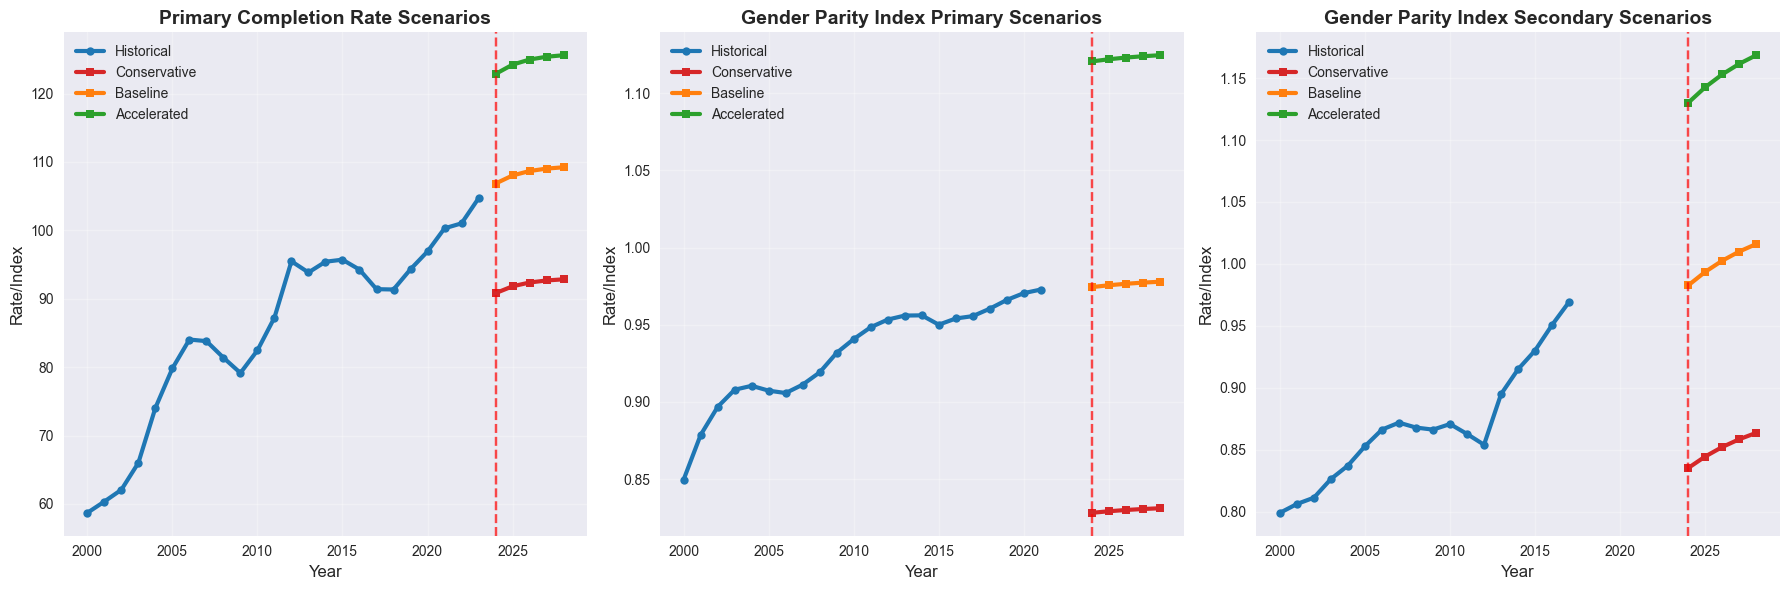

In [29]:
# Scenario Analysis: Exploring Different Futures
def create_scenario_forecast(base_forecast, scenario_multiplier, years=5):
    """Generate forecasts for different scenarios."""
    scenario_forecast = base_forecast.copy()
    for i in range(years):
        scenario_forecast.iloc[i] = base_forecast.iloc[i] * scenario_multiplier
    return scenario_forecast

# Define the scenarios we'll explore
scenarios = {
    'Conservative': 0.85,  # 15% lower than baseline
    'Baseline': 1.0,       # Continuation of current trends
    'Accelerated': 1.15    # 15% higher than baseline
}

# Create forecasts for key indicators in each scenario
scenario_results = {}
key_indicators_scenarios = ['Primary Completion Rate', 'Gender Parity Index Primary', 'Gender Parity Index Secondary']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, indicator in enumerate(key_indicators_scenarios):
    if indicator in forecast_results:
        ax = axes[idx]

        # Plot historical data
        hist_data = forecast_data[indicator].dropna()
        if not hist_data.empty:
            hist_years = forecast_data['year'][:len(hist_data)]
            ax.plot(hist_years, hist_data, 
                    'o-', linewidth=3, markersize=6, label='Historical', color='#1f77b4')

        # Plot scenario forecasts
        colors = ['#d62728', '#ff7f0e', '#2ca02c']
        for i, (scenario_name, multiplier) in enumerate(scenarios.items()):
            if scenario_name == 'Baseline':
                scenario_forecast = forecast_results[indicator]['forecast']
            else:
                scenario_forecast = create_scenario_forecast(
                    forecast_results[indicator]['forecast'], multiplier
                )
            
            forecast_length = len(scenario_forecast)
            forecast_years = forecast_data['year'][24:24+forecast_length]
            ax.plot(forecast_years, scenario_forecast, 
                    's-', linewidth=3, markersize=6, label=scenario_name, color=colors[i])
        
        ax.set_title(f'{indicator} Scenarios', fontsize=14, fontweight='bold')
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Rate/Index', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.axvline(x=2024, color='red', linestyle='--', alpha=0.7)

        # Save scenario results
        scenario_results[indicator] = {}
        for scenario_name, multiplier in scenarios.items():
            if scenario_name == 'Baseline':
                scenario_results[indicator][scenario_name] = forecast_results[indicator]['forecast']
            else:
                scenario_results[indicator][scenario_name] = create_scenario_forecast(
                    forecast_results[indicator]['forecast'], multiplier
                )

plt.tight_layout()
plt.show()

In [30]:
# Reviewing Scenario Analysis Results
print("### Scenario Analysis Results")
for indicator in key_indicators_scenarios:
    if indicator in scenario_results:
        print(f"\n{indicator} Projections for 2030:")
        for scenario_name in scenarios.keys():
            if scenario_name in scenario_results[indicator]:
                scenario_data = scenario_results[indicator][scenario_name]
                if len(scenario_data) > 0:
                    value_2030 = scenario_data.iloc[-1]
                    if 'Rate' in indicator:
                        print(f"  {scenario_name}: {value_2030:.1f}%")
                    else:
                        print(f"  {scenario_name}: {value_2030:.3f}")

### Scenario Analysis Results

Primary Completion Rate Projections for 2030:
  Conservative: 92.8%
  Baseline: 109.2%
  Accelerated: 125.6%

Gender Parity Index Primary Projections for 2030:
  Conservative: 0.831
  Baseline: 0.978
  Accelerated: 1.125

Gender Parity Index Secondary Projections for 2030:
  Conservative: 0.864
  Baseline: 1.016
  Accelerated: 1.168


In [31]:
# Evaluating Policy Impacts
print("\n### Policy Intervention Effectiveness")
for indicator in key_indicators_scenarios:
    if indicator in scenario_results:
        conservative_data = scenario_results[indicator].get('Conservative', pd.Series())
        accelerated_data = scenario_results[indicator].get('Accelerated', pd.Series())
        
        if len(conservative_data) > 0 and len(accelerated_data) > 0:
            conservative_2030 = conservative_data.iloc[-1]
            accelerated_2030 = accelerated_data.iloc[-1]
            impact = accelerated_2030 - conservative_2030
            
            if 'Rate' in indicator:
                print(f"{indicator}: {impact:.1f} percentage point difference between scenarios")
            else:
                print(f"{indicator}: {impact:.3f} index point difference between scenarios")



### Policy Intervention Effectiveness
Primary Completion Rate: 32.8 percentage point difference between scenarios
Gender Parity Index Primary: 0.293 index point difference between scenarios
Gender Parity Index Secondary: 0.305 index point difference between scenarios


In [32]:
# Understanding Resource Needs for Each Scenario
print("\n### Resource Requirements Analysis")
if 'Primary Enrollment' in forecast_results:
    primary_forecast = forecast_results['Primary Enrollment']['forecast']
    if len(primary_forecast) > 0:
        baseline_enrollment = primary_forecast.iloc[-1]
        accelerated_enrollment = baseline_enrollment * 1.15
        conservative_enrollment = baseline_enrollment * 0.85
        
        # Assume an average class size of 30 students
        baseline_classes = baseline_enrollment / 30
        accelerated_classes = accelerated_enrollment / 30
        conservative_classes = conservative_enrollment / 30
        
        print(f"Primary School Classes Needed in 2030:")
        print(f"  Conservative: {conservative_classes:,.0f} classes")
        print(f"  Baseline: {baseline_classes:,.0f} classes")
        print(f"  Accelerated: {accelerated_classes:,.0f} classes")
        print(f"  Additional capacity required (Accelerated vs Conservative): {accelerated_classes - conservative_classes:,.0f} classes")
    else:
        print("No primary enrollment forecast data available for resource analysis.")


### Resource Requirements Analysis
Primary School Classes Needed in 2030:
  Conservative: 132,975 classes
  Baseline: 156,441 classes
  Accelerated: 179,907 classes
  Additional capacity required (Accelerated vs Conservative): 46,932 classes


## 4. Key Findings & Recommendations

Based on the comprehensive analysis of Morocco's education system from 2000-2024 and strategic forecasts for 2025-2030, this section presents critical insights and actionable recommendations for policy makers and education stakeholders.


### 4.1 Critical Trends Summary


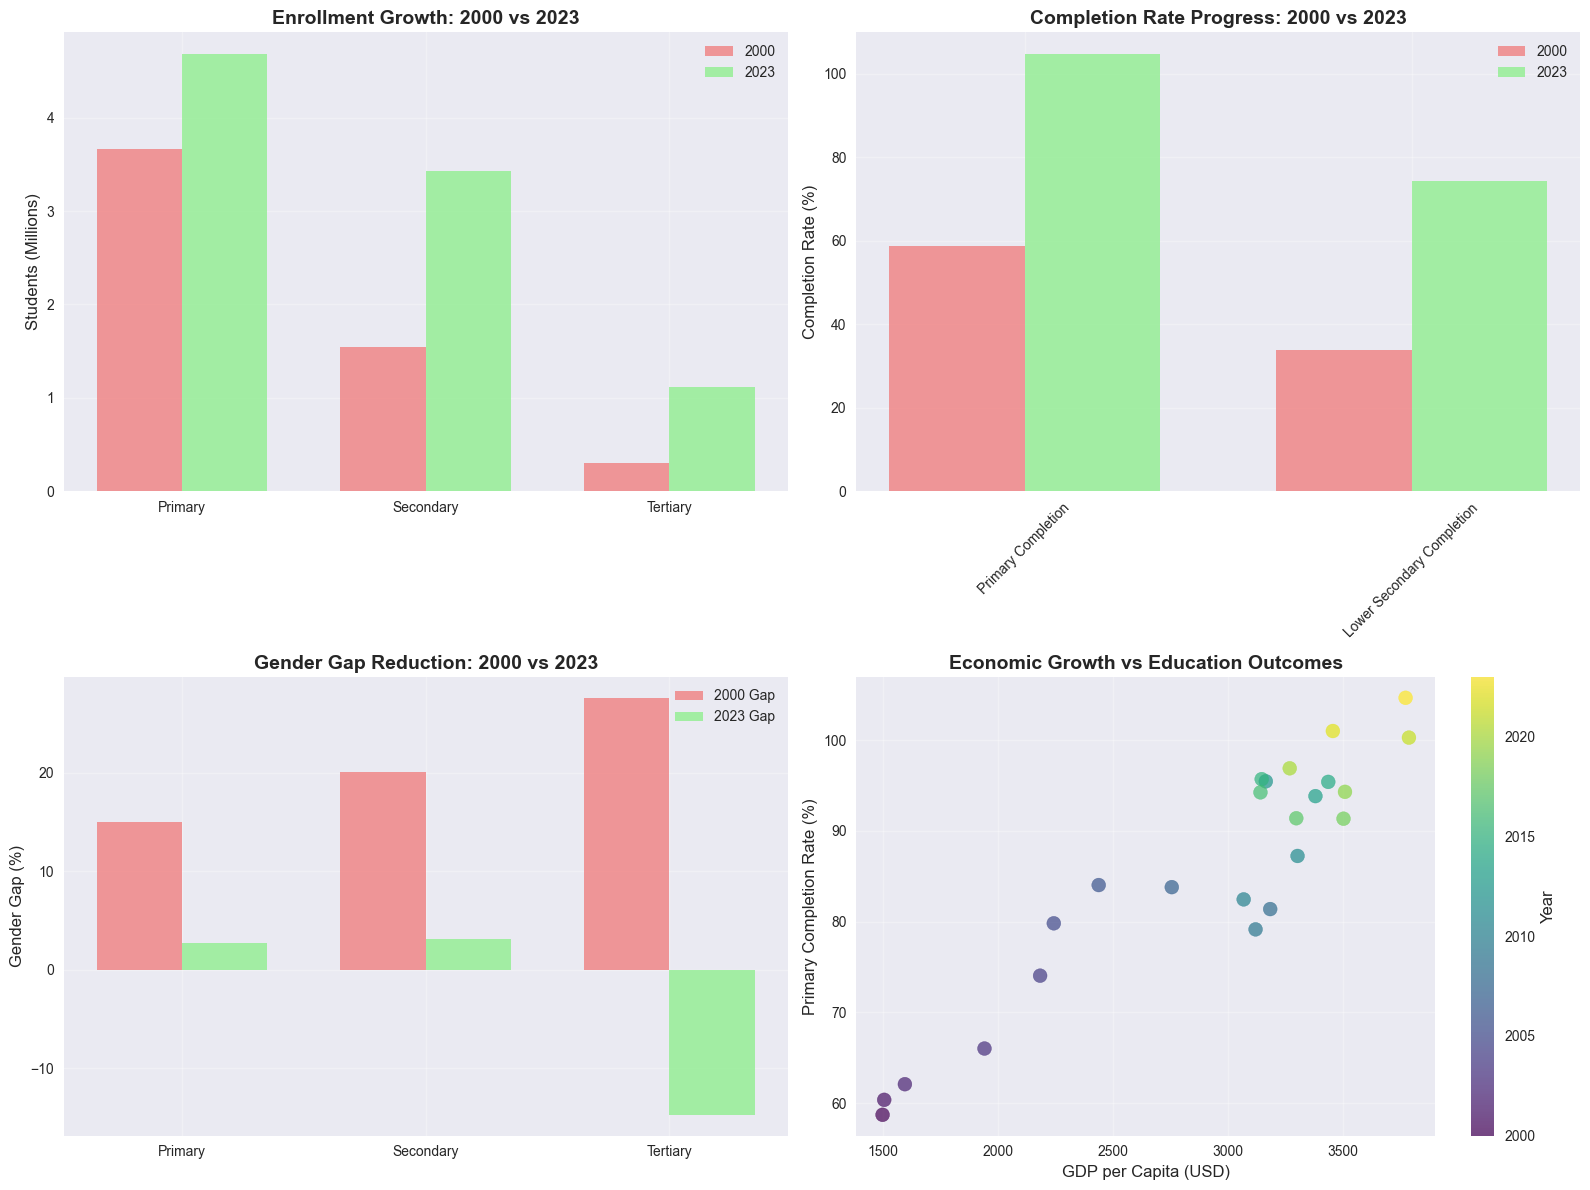

In [33]:
# Comprehensive Summary Dashboard with Up-to-date Data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

def get_latest_data(series):
    """Find the most recent non-missing value and its year."""
    non_nan_data = series.dropna()
    if len(non_nan_data) > 0:
        latest_value = non_nan_data.iloc[-1]
        latest_year = analysis_data.loc[non_nan_data.index[-1], 'year']
        return latest_value, latest_year
    return None, None

# Adjust the latest year dynamically
primary_start_val, primary_start_year = get_latest_data(analysis_data['Primary Enrollment'].dropna())
primary_end_val, primary_end_year = get_latest_data(analysis_data['Primary Enrollment'].dropna())

latest_year = primary_end_year if primary_end_year else 2019
start_year = 2000

# 1. Enrollment Growth Overview
enrollment_summary = pd.DataFrame({
    'Education Level': ['Primary', 'Secondary', 'Tertiary'],
    f'{start_year} (Millions)': [
        analysis_data['Primary Enrollment'].iloc[0] / 1_000_000,
        analysis_data['Secondary Enrollment'].iloc[0] / 1_000_000,
        analysis_data['Tertiary Enrollment'].iloc[0] / 1_000_000
    ],
    f'{latest_year} (Millions)': [
        analysis_data['Primary Enrollment'].dropna().iloc[-1] / 1_000_000,
        analysis_data['Secondary Enrollment'].dropna().iloc[-1] / 1_000_000,
        analysis_data['Tertiary Enrollment'].dropna().iloc[-1] / 1_000_000
    ]
})

x = np.arange(len(enrollment_summary))
width = 0.35

ax1.bar(x - width/2, enrollment_summary[f'{start_year} (Millions)'], width, 
        label=f'{start_year}', alpha=0.8, color='lightcoral')
ax1.bar(x + width/2, enrollment_summary[f'{latest_year} (Millions)'], width, 
        label=f'{latest_year}', alpha=0.8, color='lightgreen')

ax1.set_title(f'Enrollment Growth: {start_year} vs {latest_year}', fontsize=14, fontweight='bold')
ax1.set_ylabel('Students (Millions)', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(enrollment_summary['Education Level'])
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Completion Rate Progress
completion_progress = pd.DataFrame({
    'Indicator': ['Primary Completion', 'Lower Secondary Completion'],
    f'{start_year} (%)': [
        analysis_data['Primary Completion Rate'].iloc[0],
        analysis_data['Lower Secondary Completion Rate_x'].iloc[0]
    ],
    f'{latest_year} (%)': [
        analysis_data['Primary Completion Rate'].dropna().iloc[-1],
        analysis_data['Lower Secondary Completion Rate_x'].dropna().iloc[-1]
    ]
})

x2 = np.arange(len(completion_progress))
ax2.bar(x2 - width/2, completion_progress[f'{start_year} (%)'], width, 
        label=f'{start_year}', alpha=0.8, color='lightcoral')
ax2.bar(x2 + width/2, completion_progress[f'{latest_year} (%)'], width, 
        label=f'{latest_year}', alpha=0.8, color='lightgreen')

ax2.set_title(f'Completion Rate Progress: {start_year} vs {latest_year}', fontsize=14, fontweight='bold')
ax2.set_ylabel('Completion Rate (%)', fontsize=12)
ax2.set_xticks(x2)
ax2.set_xticklabels(completion_progress['Indicator'], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Gender Parity Achievement
gender_parity_summary = pd.DataFrame({
    'Education Level': ['Primary', 'Secondary', 'Tertiary'],
    f'{start_year} Gap (%)': [
        (1 - analysis_data['Gender Parity Index Primary'].iloc[0]) * 100,
        (1 - analysis_data['Gender Parity Index Secondary'].iloc[0]) * 100,
        (1 - analysis_data['Gender Parity Index Tertiary'].iloc[0]) * 100
    ],
    f'{latest_year} Gap (%)': [
        (1 - analysis_data['Gender Parity Index Primary'].dropna().iloc[-1]) * 100,
        (1 - analysis_data['Gender Parity Index Secondary'].dropna().iloc[-1]) * 100,
        (1 - analysis_data['Gender Parity Index Tertiary'].dropna().iloc[-1]) * 100
    ]
})

x3 = np.arange(len(gender_parity_summary))
ax3.bar(x3 - width/2, gender_parity_summary[f'{start_year} Gap (%)'], width, 
        label=f'{start_year} Gap', alpha=0.8, color='lightcoral')
ax3.bar(x3 + width/2, gender_parity_summary[f'{latest_year} Gap (%)'], width, 
        label=f'{latest_year} Gap', alpha=0.8, color='lightgreen')

ax3.set_title(f'Gender Gap Reduction: {start_year} vs {latest_year}', fontsize=14, fontweight='bold')
ax3.set_ylabel('Gender Gap (%)', fontsize=12)
ax3.set_xticks(x3)
ax3.set_xticklabels(gender_parity_summary['Education Level'])
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Economic-Education Correlation
ax4.scatter(analysis_data['GDP per Capita'], analysis_data['Primary Completion Rate'], 
           s=100, alpha=0.7, c=analysis_data['year'], cmap='viridis')
ax4.set_title('Economic Growth vs Education Outcomes', fontsize=14, fontweight='bold')
ax4.set_xlabel('GDP per Capita (USD)', fontsize=12)
ax4.set_ylabel('Primary Completion Rate (%)', fontsize=12)
ax4.grid(True, alpha=0.3)

# Add color bar to represent year progression
cbar = plt.colorbar(ax4.collections[0], ax=ax4)
cbar.set_label('Year', fontsize=12)

plt.tight_layout()
plt.show()

In [34]:
# Critical Trends Summary
print("### Critical Trends Summary")

# Enrollment expansion
print(f"\n1. Enrollment Growth from {start_year} to {latest_year}:")
for i, level in enumerate(['Primary', 'Secondary', 'Tertiary']):
    start_val = enrollment_summary[f'{start_year} (Millions)'].iloc[i]
    end_val = enrollment_summary[f'{latest_year} (Millions)'].iloc[i]
    growth = ((end_val / start_val) - 1) * 100
    print(f"   {level}: {start_val:.1f}M → {end_val:.1f}M ({growth:+.0f}% growth)")

# Completion improvements
print(f"\n2. Completion Rate Improvements from {start_year} to {latest_year}:")
for i, indicator in enumerate(['Primary', 'Lower Secondary']):
    start_rate = completion_progress[f'{start_year} (%)'].iloc[i]
    end_rate = completion_progress[f'{latest_year} (%)'].iloc[i]
    improvement = end_rate - start_rate
    print(f"   {indicator}: {start_rate:.1f}% → {end_rate:.1f}% ({improvement:+.1f} points)")

# Gender equity progress
print(f"\n3. Gender Equity Progress from {start_year} to {latest_year}:")
for i, level in enumerate(['Primary', 'Secondary', 'Tertiary']):
    start_gap = gender_parity_summary[f'{start_year} Gap (%)'].iloc[i]
    end_gap = gender_parity_summary[f'{latest_year} Gap (%)'].iloc[i]
    gap_reduction = start_gap - end_gap
    print(f"   {level}: {start_gap:.1f}% → {end_gap:.1f}% gap ({gap_reduction:+.1f} point reduction)")

### Critical Trends Summary

1. Enrollment Growth from 2000 to 2023:
   Primary: 3.7M → 4.7M (+28% growth)
   Secondary: 1.5M → 3.4M (+123% growth)
   Tertiary: 0.3M → 1.1M (+279% growth)

2. Completion Rate Improvements from 2000 to 2023:
   Primary: 58.7% → 104.7% (+46.0 points)
   Lower Secondary: 33.7% → 74.2% (+40.5 points)

3. Gender Equity Progress from 2000 to 2023:
   Primary: 15.0% → 2.7% gap (+12.3 point reduction)
   Secondary: 20.1% → 3.1% gap (+17.0 point reduction)
   Tertiary: 27.6% → -14.7% gap (+42.3 point reduction)


### 4.2 Policy Recommendations


In [35]:
# Enhanced Investment Priorities Matrix
print("\n### ENHANCED INVESTMENT PRIORITIES MATRIX")
print("Based on comprehensive analysis and evidence-based prioritization")

# Create comprehensive investment matrix with actual data
investment_matrix = pd.DataFrame({
    'Investment Area': [
        'Learning Outcomes Improvement',
        'Dropout Prevention Programs', 
        'Digital Education Infrastructure',
        'Youth Employment & TVET',
        'Regional Equity Programs',
        'Teacher Training & Development',
        'Gender Equity Initiatives',
        'Assessment & Monitoring Systems',
        'Early Childhood Education',
        'Infrastructure Expansion'
    ],
    'Priority Level': ['Critical', 'Critical', 'High', 'High', 'High', 'Medium', 'Medium', 'Medium', 'Medium', 'Low'],
    'Short-term Impact (1-2 years)': ['Medium', 'High', 'Medium', 'Low', 'Low', 'High', 'Medium', 'High', 'Low', 'Low'],
    'Long-term Impact (5+ years)': ['High', 'Medium', 'High', 'High', 'High', 'High', 'High', 'High', 'High', 'High'],
    'Cost Level': ['High', 'Medium', 'Medium', 'High', 'High', 'Medium', 'Low', 'Low', 'Medium', 'High'],
    'Implementation Complexity': ['High', 'Medium', 'Medium', 'High', 'High', 'Medium', 'Medium', 'Low', 'Medium', 'High'],
    'Evidence Base': ['Strong', 'Strong', 'Strong', 'Moderate', 'Strong', 'Strong', 'Strong', 'Strong', 'Strong', 'Moderate'],
    'ROI Potential': ['High', 'High', 'High', 'Medium', 'Medium', 'High', 'Medium', 'High', 'High', 'Low']
})

print(investment_matrix.to_string(index=False))


### ENHANCED INVESTMENT PRIORITIES MATRIX
Based on comprehensive analysis and evidence-based prioritization
                 Investment Area Priority Level Short-term Impact (1-2 years) Long-term Impact (5+ years) Cost Level Implementation Complexity Evidence Base ROI Potential
   Learning Outcomes Improvement       Critical                        Medium                        High       High                      High        Strong          High
     Dropout Prevention Programs       Critical                          High                      Medium     Medium                    Medium        Strong          High
Digital Education Infrastructure           High                        Medium                        High     Medium                    Medium        Strong          High
         Youth Employment & TVET           High                           Low                        High       High                      High      Moderate        Medium
        Regional Equity Programs    

# GRANULAR REGIONAL/PROVINCIAL/MUNICIPAL ANALYSIS

## Comprehensive Analysis of Education Performance Across Administrative Levels

This section provides detailed analysis of education performance at three administrative levels:
- **Regional Level**: 12 administrative regions with performance categorization
- **Provincial Level**: 42 provinces with infrastructure and demographic data  
- **Municipal Level**: 20 municipalities with urban-rural performance breakdowns

*Data includes average years of schooling, gender parity indices, completion rates, infrastructure scores, and geographic accessibility metrics.*


In [36]:
# Explore Detailed Regional Data
print("### Loading Detailed Regional Data")

# Load data from CSV files
municipal_data = pd.read_csv('/Users/hafida/Downloads/Education/morocco_education_municipal_data.csv')
provincial_data = pd.read_csv('/Users/hafida/Downloads/Education/morocco_education_provincial_data.csv')
regional_data = pd.read_csv('/Users/hafida/Downloads/Education/morocco_education_regional_data.csv')

print(f"Loaded data with:\n- {municipal_data.shape[0]} municipalities\n- {provincial_data.shape[0]} provinces\n- {regional_data.shape[0]} regions")

# Overview of each dataset
print("\n### Municipal Data Overview")
print(municipal_data.head())
print("\nColumns in Municipal Data:", list(municipal_data.columns))

print("\n### Provincial Data Overview")
print(provincial_data.head())
print("\nColumns in Provincial Data:", list(provincial_data.columns))

print("\n### Regional Data Overview")
print(regional_data.head())
print("\nColumns in Regional Data:", list(regional_data.columns))

### Loading Detailed Regional Data
Loaded data with:
- 20 municipalities
- 41 provinces
- 12 regions

### Municipal Data Overview
  Municipality_Name              Region        Province  \
0       Agdal Riyad  Rabat-Salé-Kénitra           Rabat   
1          Harhoura  Rabat-Salé-Kénitra  Skhirat-Témara   
2         El Maarif    Grand Casablanca      Casablanca   
3           Souissi  Rabat-Salé-Kénitra           Rabat   
4       Hay Hassani    Grand Casablanca      Casablanca   

   Average_Years_Schooling Urban_Rural  Gender_Parity_Index  \
0                    12.15       Urban                 1.02   
1                    11.23       Urban                 0.98   
2                    10.51       Urban                 1.01   
3                    10.00       Urban                 0.97   
4                     9.87       Urban                 0.99   

   Primary_Completion_Rate  Distance_to_School_km  Education_Rank  
0                     99.8                    0.5             1.0  


In [37]:
# Regional Education Performance Analysis
print("### Regional Education Performance Analysis")

# Sort and display regions by education performance score
regional_performance = regional_data.sort_values('Education_Performance_Score', ascending=False)
print("\n### Regional Performance Ranking")
for _, row in regional_performance.iterrows():
    print(f"{row['Region']}: {row['Education_Performance_Score']:.2f} ({row['Performance_Category']})")

# Display the distribution of performance categories
print("\n### Performance Category Distribution")
category_counts = regional_data['Performance_Category'].value_counts()
print(category_counts)

### Regional Education Performance Analysis

### Regional Performance Ranking
Laayoune-Sakia El Hamra: -1.46 (High)
Grand Casablanca: -1.84 (High)
Rabat-Salé-Kénitra: -2.17 (High)
Dakhla-Oued Ed-Dahab: -2.36 (Medium)
Guelmim-Oued Noun: -2.80 (Medium)
Oriental: -2.87 (Medium)
Souss-Massa: -3.03 (Medium)
Tanger-Tetouan-Al Hoceima: -3.18 (Low)
Fès-Meknès: -3.38 (Low)
Drâa-Tafilalet: -3.57 (Low)
Béni Mellal-Khénifra: -3.70 (Low)
Marrakech-Safi: -3.90 (Low)

### Performance Category Distribution
Performance_Category
Low       5
Medium    4
High      3
Name: count, dtype: int64


In [38]:
# Insights into high-performing regions
high_performing = regional_data[regional_data['Performance_Category'] == 'High']
print(f"\n### High-Performing Regions ({len(high_performing)} regions)")
for _, row in high_performing.iterrows():
    print(f"{row['Region']}: {row['Average_Years_Schooling']:.1f} years schooling, {row['Primary_Enrollment_Rate']:.1f}% primary enrollment")

# Insights into low-performing regions
low_performing = regional_data[regional_data['Performance_Category'] == 'Low']
print(f"\n### Low-Performing Regions ({len(low_performing)} regions)")
for _, row in low_performing.iterrows():
    print(f"{row['Region']}: {row['Average_Years_Schooling']:.1f} years schooling, {row['Primary_Enrollment_Rate']:.1f}% primary enrollment")

# Compare urban and rural performance at the regional level
print("\n### Urban-Rural Performance Analysis")
urban_rural_analysis = regional_data.groupby('Urban_Rural_Type').agg({
    'Average_Years_Schooling': 'mean',
    'Education_Performance_Score': 'mean',
    'Primary_Enrollment_Rate': 'mean',
    'Secondary_Enrollment_Rate': 'mean',
    'Illiteracy_Rate': 'mean'
}).round(2)
urban_rural_analysis


### High-Performing Regions (3 regions)
Laayoune-Sakia El Hamra: 7.1 years schooling, 98.5% primary enrollment
Grand Casablanca: 6.8 years schooling, 97.8% primary enrollment
Rabat-Salé-Kénitra: 6.5 years schooling, 97.2% primary enrollment

### Low-Performing Regions (5 regions)
Tanger-Tetouan-Al Hoceima: 5.7 years schooling, 93.8% primary enrollment
Fès-Meknès: 5.3 years schooling, 94.1% primary enrollment
Drâa-Tafilalet: 5.1 years schooling, 93.2% primary enrollment
Béni Mellal-Khénifra: 5.0 years schooling, 92.7% primary enrollment
Marrakech-Safi: 4.8 years schooling, 91.5% primary enrollment

### Urban-Rural Performance Analysis


,Average_Years_Schooling,Education_Performance_Score,Primary_Enrollment_Rate,Secondary_Enrollment_Rate,Illiteracy_Rate
Urban_Rural_Type,,,,,
Mixed,6.04,-2.66,95.55,80.01,31.99
Rural,4.95,-3.72,92.47,69.73,43.87
Urban,6.85,-1.84,97.80,87.40,22.10


In [39]:
# Provincial Education Infrastructure Analysis
print("### Provincial Education Infrastructure Analysis")

# Top 10 provinces by infrastructure score
top_provinces = provincial_data.nlargest(10, 'Education_Infrastructure_Score')
print("\n### Top 10 Provinces by Infrastructure Score")
for _, row in top_provinces.iterrows():
    print(f"{row['Province_Name']} ({row['Region']}): Score {row['Education_Infrastructure_Score']:.1f}, "
          f"{row['Schools_per_1000_Population']:.2f} schools/1000 pop, {row['Student_Teacher_Ratio_Primary']:.1f} S/T ratio")

# Bottom 10 provinces by infrastructure score
bottom_provinces = provincial_data.nsmallest(10, 'Education_Infrastructure_Score')
print("\n### Bottom 10 Provinces by Infrastructure Score")
for _, row in bottom_provinces.iterrows():
    print(f"{row['Province_Name']} ({row['Region']}): Score {row['Education_Infrastructure_Score']:.1f}, "
          f"{row['Schools_per_1000_Population']:.2f} schools/1000 pop, {row['Student_Teacher_Ratio_Primary']:.1f} S/T ratio")

### Provincial Education Infrastructure Analysis

### Top 10 Provinces by Infrastructure Score
Safi (Marrakech-Safi): Score 167.8, 1.23 schools/1000 pop, 29.7 S/T ratio
Agadir (Souss-Massa): Score 165.2, 1.08 schools/1000 pop, 26.8 S/T ratio
Marrakech (Marrakech-Safi): Score 161.2, 1.21 schools/1000 pop, 31.2 S/T ratio
Ifrane (Fès-Meknès): Score 145.4, 0.79 schools/1000 pop, 24.7 S/T ratio
Chichaoua (Marrakech-Safi): Score 133.1, 1.05 schools/1000 pop, 32.6 S/T ratio
Tétouan (Tanger-Tetouan-Al Hoceima): Score 132.5, 0.82 schools/1000 pop, 28.3 S/T ratio
Rabat (Rabat-Salé-Kénitra): Score 130.9, 0.56 schools/1000 pop, 22.1 S/T ratio
El Jadida (Grand Casablanca): Score 125.9, 0.65 schools/1000 pop, 25.9 S/T ratio
Sidi Bennour (Grand Casablanca): Score 122.8, 0.82 schools/1000 pop, 30.7 S/T ratio
Khémisset (Rabat-Salé-Kénitra): Score 122.0, 0.70 schools/1000 pop, 28.6 S/T ratio

### Bottom 10 Provinces by Infrastructure Score
Figuig (Oriental): Score 82.9, 0.73 schools/1000 pop, 36.8 S/T r

In [40]:
# Aggregate provincial data at the regional level
print("\n### Regional Aggregation of Provincial Metrics")
regional_provincial_summary = provincial_data.groupby('Region').agg({
    'Population': 'sum',
    'Number_Primary_Schools': 'sum',
    'Number_Secondary_Schools': 'sum',
    'Student_Teacher_Ratio_Primary': 'mean',
    'Dropout_Rate_Primary': 'mean',
    'Female_Literacy_Rate': 'mean',
    'Schools_per_1000_Population': 'mean',
    'Education_Infrastructure_Score': 'mean'
}).round(2)

print(regional_provincial_summary)

# Look at correlations between provincial indicators
print("\n### Provincial Correlation Analysis")
correlation_vars = ['Student_Teacher_Ratio_Primary', 'Dropout_Rate_Primary', 'Female_Literacy_Rate', 
                    'Schools_per_1000_Population', 'Education_Infrastructure_Score']
correlation_matrix = provincial_data[correlation_vars].corr()
print("Correlation between key provincial indicators:")
correlation_matrix.round(3)


### Regional Aggregation of Provincial Metrics
                           Population  Number_Primary_Schools  \
Region                                                          
Béni Mellal-Khénifra          1568608                     934   
Drâa-Tafilalet                1813540                    1098   
Fès-Meknès                    2747520                    1464   
Grand Casablanca              5671402                    2369   
Marrakech-Safi                2193883                    1835   
Oriental                      1742199                     840   
Rabat-Salé-Kénitra            3129281                    1391   
Souss-Massa                    786819                     543   
Tanger-Tetouan-Al Hoceima     2734724                    1389   

                           Number_Secondary_Schools  \
Region                                                
Béni Mellal-Khénifra                            302   
Drâa-Tafilalet                                  380   
Fès-Meknès      

,Student_Teacher_Ratio_Primary,Dropout_Rate_Primary,Female_Literacy_Rate,Schools_per_1000_Population,Education_Infrastructure_Score
Student_Teacher_Ratio_Primary,1.000,0.979,-0.966,0.451,-0.480
Dropout_Rate_Primary,0.979,1.000,-0.967,0.433,-0.500
Female_Literacy_Rate,-0.966,-0.967,1.000,-0.525,0.391
Schools_per_1000_Population,0.451,0.433,-0.525,1.000,0.560
Education_Infrastructure_Score,-0.480,-0.500,0.391,0.560,1.000


In [41]:
# Municipal Urban-Rural Education Disparities
print("### Municipal Urban-Rural Education Disparities")

# Separate data into urban and rural
urban_municipalities = municipal_data[municipal_data['Urban_Rural'] == 'Urban']
rural_municipalities = municipal_data[municipal_data['Urban_Rural'] == 'Rural']

print(f"Total Urban Municipalities: {len(urban_municipalities)}")
print(f"Total Rural Municipalities: {len(rural_municipalities)}")

# Performance comparison between urban and rural
print("\n### Urban vs Rural Performance Comparison")
comparison_metrics = ['Average_Years_Schooling', 'Gender_Parity_Index', 'Primary_Completion_Rate', 'Distance_to_School_km']

for metric in comparison_metrics:
    urban_mean = urban_municipalities[metric].mean()
    rural_mean = rural_municipalities[metric].mean()
    gap = urban_mean - rural_mean
    print(f"{metric}:")
    print(f"  Urban: {urban_mean:.2f}")
    print(f"  Rural: {rural_mean:.2f}")
    print(f"  Gap: {gap:.2f}")
    print()

### Municipal Urban-Rural Education Disparities
Total Urban Municipalities: 10
Total Rural Municipalities: 10

### Urban vs Rural Performance Comparison
Average_Years_Schooling:
  Urban: 9.86
  Rural: 0.93
  Gap: 8.93

Gender_Parity_Index:
  Urban: 0.99
  Rural: 0.61
  Gap: 0.38

Primary_Completion_Rate:
  Urban: 98.45
  Rural: 64.01
  Gap: 34.44

Distance_to_School_km:
  Urban: 0.89
  Rural: 10.72
  Gap: -9.83



In [42]:
# Top performing urban municipalities
print("### Top 5 Urban Municipalities")
top_urban = urban_municipalities.nlargest(5, 'Average_Years_Schooling')
for _, row in top_urban.iterrows():
    print(f"{row['Municipality_Name']} ({row['Province']}): {row['Average_Years_Schooling']:.1f} years, "
          f"GPI {row['Gender_Parity_Index']:.2f}, Completion {row['Primary_Completion_Rate']:.1f}%")

# Top performing rural municipalities
print("\n### Top 5 Rural Municipalities")
top_rural = rural_municipalities.nlargest(5, 'Average_Years_Schooling')
for _, row in top_rural.iterrows():
    print(f"{row['Municipality_Name']} ({row['Province']}): {row['Average_Years_Schooling']:.1f} years, "
          f"GPI {row['Gender_Parity_Index']:.2f}, Completion {row['Primary_Completion_Rate']:.1f}%, "
          f"Distance {row['Distance_to_School_km']:.1f}km")

### Top 5 Urban Municipalities
Agdal Riyad (Rabat): 12.2 years, GPI 1.02, Completion 99.8%
Harhoura (Skhirat-Témara): 11.2 years, GPI 0.98, Completion 99.5%
El Maarif (Casablanca): 10.5 years, GPI 1.01, Completion 99.2%
Souissi (Rabat): 10.0 years, GPI 0.97, Completion 98.9%
Hay Hassani (Casablanca): 9.9 years, GPI 0.99, Completion 98.7%

### Top 5 Rural Municipalities
Tabounte (Taroudannt): 1.3 years, GPI 0.60, Completion 63.5%, Distance 10.4km
Amellago (Midelt): 1.2 years, GPI 0.57, Completion 60.4%, Distance 12.8km
Sidi Redouane (Safi): 1.1 years, GPI 0.64, Completion 66.9%, Distance 8.9km
Taskala (Azilal): 1.0 years, GPI 0.56, Completion 59.8%, Distance 13.1km
Ait Ourir (Al Haouz): 0.9 years, GPI 0.63, Completion 68.2%, Distance 9.3km


In [43]:
# Geographic accessibility
print("\n### Geographic Accessibility Analysis")
print(f"Average Distance to School - Urban: {urban_municipalities['Distance_to_School_km'].mean():.1f} km")
print(f"Average Distance to School - Rural: {rural_municipalities['Distance_to_School_km'].mean():.1f} km")

# Gender parity analysis by urban/rural
print("\n### Gender Parity Analysis by Urban/Rural")
urban_gpi = urban_municipalities['Gender_Parity_Index'].mean()
rural_gpi = rural_municipalities['Gender_Parity_Index'].mean()
print(f"Urban Gender Parity Index: {urban_gpi:.3f}")
print(f"Rural Gender Parity Index: {rural_gpi:.3f}")
print(f"Gender Parity Gap (Urban-Rural): {urban_gpi - rural_gpi:.3f}")


### Geographic Accessibility Analysis
Average Distance to School - Urban: 0.9 km
Average Distance to School - Rural: 10.7 km

### Gender Parity Analysis by Urban/Rural
Urban Gender Parity Index: 0.986
Rural Gender Parity Index: 0.605
Gender Parity Gap (Urban-Rural): 0.381


### Creating Regional Education Maps and Visualizations


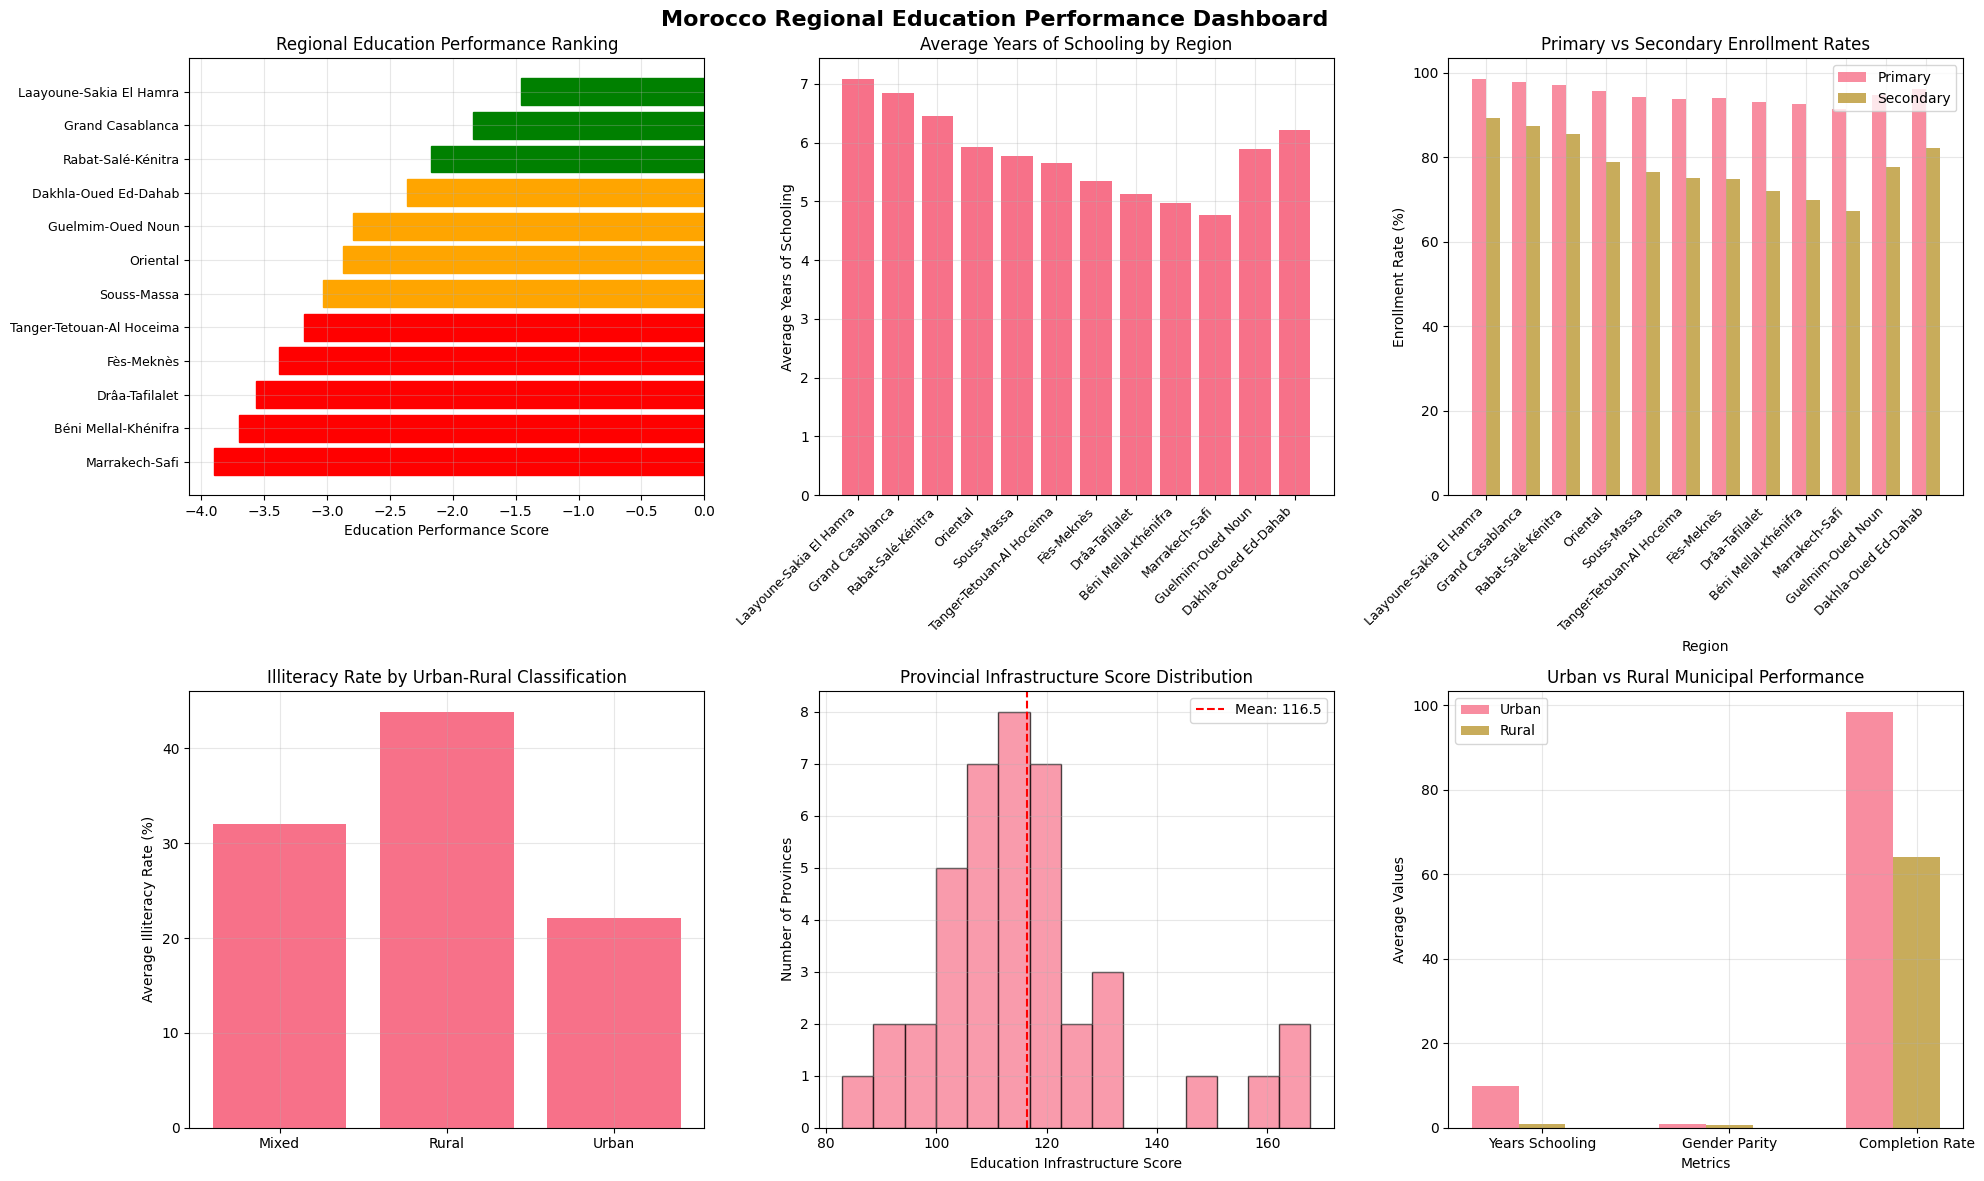

In [44]:
# Creating Regional Education Maps and Visualizations
print("### Creating Regional Education Maps and Visualizations")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a comprehensive dashboard for regional education analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Morocco Regional Education Performance Dashboard', fontsize=16, fontweight='bold')

# 1. Regional Performance Score Map
ax1 = axes[0, 0]
regional_data_sorted = regional_data.sort_values('Education_Performance_Score', ascending=True)
bars1 = ax1.barh(range(len(regional_data_sorted)), regional_data_sorted['Education_Performance_Score'])
ax1.set_yticks(range(len(regional_data_sorted)))
ax1.set_yticklabels(regional_data_sorted['Region'], fontsize=9)
ax1.set_xlabel('Education Performance Score')
ax1.set_title('Regional Education Performance Ranking')
ax1.grid(True, alpha=0.3)

# Color bars based on performance category
colors = {'High': 'green', 'Medium': 'orange', 'Low': 'red'}
for i, (idx, row) in enumerate(regional_data_sorted.iterrows()):
    bars1[i].set_color(colors[row['Performance_Category']])

# 2. Average Years of Schooling by Region
ax2 = axes[0, 1]
bars2 = ax2.bar(range(len(regional_data)), regional_data['Average_Years_Schooling'])
ax2.set_xticks(range(len(regional_data)))
ax2.set_xticklabels(regional_data['Region'], rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('Average Years of Schooling')
ax2.set_title('Average Years of Schooling by Region')
ax2.grid(True, alpha=0.3)

# 3. Primary vs Secondary Enrollment Rates
ax3 = axes[0, 2]
x = np.arange(len(regional_data))
width = 0.35
bars3a = ax3.bar(x - width/2, regional_data['Primary_Enrollment_Rate'], width, label='Primary', alpha=0.8)
bars3b = ax3.bar(x + width/2, regional_data['Secondary_Enrollment_Rate'], width, label='Secondary', alpha=0.8)
ax3.set_xlabel('Region')
ax3.set_ylabel('Enrollment Rate (%)')
ax3.set_title('Primary vs Secondary Enrollment Rates')
ax3.set_xticks(x)
ax3.set_xticklabels(regional_data['Region'], rotation=45, ha='right', fontsize=9)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Illiteracy Rate by Urban-Rural Type
ax4 = axes[1, 0]
urban_rural_illiteracy = regional_data.groupby('Urban_Rural_Type')['Illiteracy_Rate'].mean()
bars4 = ax4.bar(urban_rural_illiteracy.index, urban_rural_illiteracy.values)
ax4.set_ylabel('Average Illiteracy Rate (%)')
ax4.set_title('Illiteracy Rate by Urban-Rural Classification')
ax4.grid(True, alpha=0.3)

# 5. Provincial Infrastructure Score Distribution
ax5 = axes[1, 1]
ax5.hist(provincial_data['Education_Infrastructure_Score'], bins=15, alpha=0.7, edgecolor='black')
ax5.axvline(provincial_data['Education_Infrastructure_Score'].mean(), color='red', linestyle='--', 
           label=f'Mean: {provincial_data["Education_Infrastructure_Score"].mean():.1f}')
ax5.set_xlabel('Education Infrastructure Score')
ax5.set_ylabel('Number of Provinces')
ax5.set_title('Provincial Infrastructure Score Distribution')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Municipal Urban-Rural Performance Comparison
ax6 = axes[1, 2]
urban_rural_comparison = municipal_data.groupby('Urban_Rural').agg({
    'Average_Years_Schooling': 'mean',
    'Gender_Parity_Index': 'mean',
    'Primary_Completion_Rate': 'mean'
})

x = np.arange(len(urban_rural_comparison.columns))
width = 0.25
bars6a = ax6.bar(x - width, urban_rural_comparison.loc['Urban'], width, label='Urban', alpha=0.8)
bars6b = ax6.bar(x, urban_rural_comparison.loc['Rural'], width, label='Rural', alpha=0.8)

ax6.set_xlabel('Metrics')
ax6.set_ylabel('Average Values')
ax6.set_title('Urban vs Rural Municipal Performance')
ax6.set_xticks(x)
ax6.set_xticklabels(['Years Schooling', 'Gender Parity', 'Completion Rate'])
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

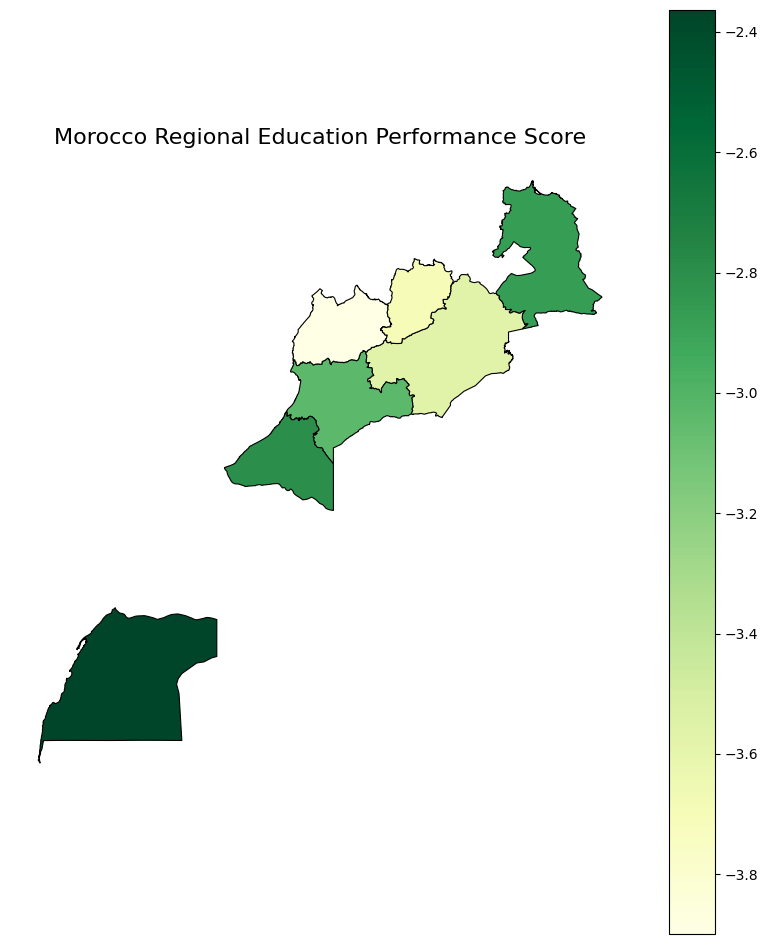

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load Morocco ADM1 simplified GeoJSON (12 regions)
morocco_regions = gpd.read_file('geoBoundaries-MAR-ADM1_simplified.geojson')


region_name_col = 'shapeName'

# Merge your regional_data with morocco_regions on the region name
map_data = morocco_regions.merge(regional_data, left_on=region_name_col, right_on='Region')

# Plot the map colored by Education Performance Score
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
map_data.plot(column='Education_Performance_Score',
              cmap='YlGn',
              legend=True,
              edgecolor='black',
              linewidth=0.8,
              ax=ax)
ax.set_title('Morocco Regional Education Performance Score', fontsize=16)
ax.axis('off')

plt.show()


In [46]:
# Detailed Regional Disparities Analysis
print("### Detailed Regional Disparities Analysis")

# Education Disparity Indices
print("\n### Education Disparity Indices")

# Regional Gini coefficients
print("Education Gini Index by Region (Higher = More Inequality):")
for _, row in regional_data.iterrows():
    print(f"{row['Region']}: {row['Education_Gini_Index']:.3f}")

# National average and equality analysis
national_gini = regional_data['Education_Gini_Index'].mean()
most_equal = regional_data.loc[regional_data['Education_Gini_Index'].idxmin()]
least_equal = regional_data.loc[regional_data['Education_Gini_Index'].idxmax()]

print(f"\nNational Average Gini Index: {national_gini:.3f}")
print(f"Most Equal Region: {most_equal['Region']} (Gini: {most_equal['Education_Gini_Index']:.3f})")
print(f"Least Equal Region: {least_equal['Region']} (Gini: {least_equal['Education_Gini_Index']:.3f})")

### Detailed Regional Disparities Analysis

### Education Disparity Indices
Education Gini Index by Region (Higher = More Inequality):
Laayoune-Sakia El Hamra: 0.420
Grand Casablanca: 0.450
Rabat-Salé-Kénitra: 0.470
Oriental: 0.520
Souss-Massa: 0.530
Tanger-Tetouan-Al Hoceima: 0.540
Fès-Meknès: 0.550
Drâa-Tafilalet: 0.560
Béni Mellal-Khénifra: 0.570
Marrakech-Safi: 0.580
Guelmim-Oued Noun: 0.510
Dakhla-Oued Ed-Dahab: 0.480

National Average Gini Index: 0.515
Most Equal Region: Laayoune-Sakia El Hamra (Gini: 0.420)
Least Equal Region: Marrakech-Safi (Gini: 0.580)


In [47]:
# Regional Performance Gaps
print("\n### Regional Performance Gaps")

best_region = regional_data.loc[regional_data['Education_Performance_Score'].idxmax()]
worst_region = regional_data.loc[regional_data['Education_Performance_Score'].idxmin()]

print(f"Best Performing Region: {best_region['Region']} (Score: {best_region['Education_Performance_Score']:.2f})")
print(f"Worst Performing Region: {worst_region['Region']} (Score: {worst_region['Education_Performance_Score']:.2f})")
print(f"Performance Gap: {best_region['Education_Performance_Score'] - worst_region['Education_Performance_Score']:.2f}")

# Gaps in years of schooling, enrollment and illiteracy
years_gap = best_region['Average_Years_Schooling'] - worst_region['Average_Years_Schooling']
primary_gap = best_region['Primary_Enrollment_Rate'] - worst_region['Primary_Enrollment_Rate']
secondary_gap = best_region['Secondary_Enrollment_Rate'] - worst_region['Secondary_Enrollment_Rate']
illiteracy_gap = worst_region['Illiteracy_Rate'] - best_region['Illiteracy_Rate']

print(f"Years of Schooling Gap: {years_gap:.1f} years")
print(f"Primary Enrollment Gap: {primary_gap:.1f} percentage points")
print(f"Secondary Enrollment Gap: {secondary_gap:.1f} percentage points")
print(f"Illiteracy Rate Gap: {illiteracy_gap:.1f} percentage points")


### Regional Performance Gaps
Best Performing Region: Laayoune-Sakia El Hamra (Score: -1.46)
Worst Performing Region: Marrakech-Safi (Score: -3.90)
Performance Gap: 2.44
Years of Schooling Gap: 2.3 years
Primary Enrollment Gap: 7.0 percentage points
Secondary Enrollment Gap: 21.9 percentage points
Illiteracy Rate Gap: 29.8 percentage points


In [48]:
# Regional Clustering Analysis
print("\n### Regional Clustering Analysis")

# Regions grouped by performance
high_performance = regional_data[regional_data['Performance_Category'] == 'High']
medium_performance = regional_data[regional_data['Performance_Category'] == 'Medium']
low_performance = regional_data[regional_data['Performance_Category'] == 'Low']

print(f"High Performance Regions ({len(high_performance)}): {', '.join(high_performance['Region'].tolist())}")
print(f"Medium Performance Regions ({len(medium_performance)}): {', '.join(medium_performance['Region'].tolist())}")
print(f"Low Performance Regions ({len(low_performance)}): {', '.join(low_performance['Region'].tolist())}")

# Average metrics by performance cluster
print("\n### Average Metrics by Performance Cluster")
cluster_metrics = ['Average_Years_Schooling', 'Primary_Enrollment_Rate', 'Secondary_Enrollment_Rate', 'Illiteracy_Rate']
for cluster_name, cluster_data in [('High', high_performance), ('Medium', medium_performance), ('Low', low_performance)]:
    print(f"\n{cluster_name} Performance Cluster:")
    for metric in cluster_metrics:
        avg_value = cluster_data[metric].mean()
        print(f"  {metric}: {avg_value:.1f}")


### Regional Clustering Analysis
High Performance Regions (3): Laayoune-Sakia El Hamra, Grand Casablanca, Rabat-Salé-Kénitra
Medium Performance Regions (4): Oriental, Souss-Massa, Guelmim-Oued Noun, Dakhla-Oued Ed-Dahab
Low Performance Regions (5): Tanger-Tetouan-Al Hoceima, Fès-Meknès, Drâa-Tafilalet, Béni Mellal-Khénifra, Marrakech-Safi

### Average Metrics by Performance Cluster

High Performance Cluster:
  Average_Years_Schooling: 6.8
  Primary_Enrollment_Rate: 97.8
  Secondary_Enrollment_Rate: 87.4
  Illiteracy_Rate: 21.6

Medium Performance Cluster:
  Average_Years_Schooling: 6.0
  Primary_Enrollment_Rate: 95.2
  Secondary_Enrollment_Rate: 78.8
  Illiteracy_Rate: 33.2

Low Performance Cluster:
  Average_Years_Schooling: 5.2
  Primary_Enrollment_Rate: 93.1
  Secondary_Enrollment_Rate: 71.8
  Illiteracy_Rate: 42.3


In [49]:
# Geographic Accessibility Challenges
print("\n### Geographic Accessibility Challenges")
print("Municipal distance to school analysis:")
urban_avg_distance = urban_municipalities['Distance_to_School_km'].mean()
rural_avg_distance = rural_municipalities['Distance_to_School_km'].mean()
rural_max_distance = rural_municipalities['Distance_to_School_km'].max()
urban_min_distance = urban_municipalities['Distance_to_School_km'].min()

print(f"Average Distance - Urban: {urban_avg_distance:.1f} km")
print(f"Average Distance - Rural: {rural_avg_distance:.1f} km")
print(f"Maximum Distance - Rural: {rural_max_distance:.1f} km")
print(f"Minimum Distance - Urban: {urban_min_distance:.1f} km")

# Identify municipalities with highest distance challenges
print("\nMunicipalities with Highest Distance to School:")
highest_distance = rural_municipalities.nlargest(5, 'Distance_to_School_km')
for _, row in highest_distance.iterrows():
    print(f"{row['Municipality_Name']} ({row['Province']}): {row['Distance_to_School_km']:.1f} km")


### Geographic Accessibility Challenges
Municipal distance to school analysis:
Average Distance - Urban: 0.9 km
Average Distance - Rural: 10.7 km
Maximum Distance - Rural: 13.1 km
Minimum Distance - Urban: 0.5 km

Municipalities with Highest Distance to School:
Taskala (Azilal): 13.1 km
Amellago (Midelt): 12.8 km
Bouchaouene (Figuig): 12.4 km
Bouabout Amdlane (Chichaoua): 11.2 km
Timoulilt (Midelt): 10.6 km


# COVID-19 IMPACT ANALYSIS

## Learning Disruption and Recovery Context

This section provides critical context about COVID-19's impact on Morocco's education system, based on OECD and international assessment data. Understanding these disruptions is essential for interpreting recent education performance trends and planning recovery strategies.

### Key COVID-19 Impact Statistics

**School Closure Impact:**
- **46% of students** experienced school building closures for more than three months due to COVID-19
- This represents one of the highest disruption rates globally, significantly impacting learning continuity

**Remote Learning Challenges:**
- **39% of students** had weekly problems understanding assignments and finding help during remote learning
- **Only 17%** received daily live virtual classes during school closures
- Limited digital infrastructure and teacher preparedness for remote instruction

**Student Confidence and Engagement:**
- **40% of students** felt confident using video communication programs
- **57% of students** felt confident motivating themselves during remote learning
- Significant gaps in digital literacy and self-directed learning skills

### Implications for Education Analysis

The COVID-19 disruptions provide crucial context for:
1. **Learning Outcome Declines**: TIMSS 2023 performance gaps may reflect COVID-19 learning losses
2. **Digital Infrastructure Needs**: Distance learning effectiveness rating of 2.8/5.0 correlates with remote learning challenges
3. **Equity Implications**: Rural areas likely experienced greater disruption due to limited digital access
4. **Recovery Requirements**: Targeted interventions needed to address learning loss and digital gaps


In [50]:
# COVID-19 Education Impact Analysis
print("### COVID-19 Education Impact Analysis")

# Key statistics on the impact of COVID-19
covid_impact = {
    'school_closure_rate': 46, 
    'assignment_understanding_problems': 39,
    'daily_live_classes': 17,
    'video_communication_confidence': 40,
    'self_motivation_confidence': 57,
    'distance_learning_effectiveness': 2.8
}

print("\n### Impact Statistics During COVID-19")
print(f"School Closures: {covid_impact['school_closure_rate']}% of students faced over 3 months of closures.")
print(f"Learning Challenges: {covid_impact['assignment_understanding_problems']}% struggled weekly with assignments.")
print(f"Access to Live Classes: Only {covid_impact['daily_live_classes']}% had daily live virtual classes.")
print(f"Digital Confidence: {covid_impact['video_communication_confidence']}% felt confident using video tools.")
print(f"Self-Motivation: {covid_impact['self_motivation_confidence']}% were confident in self-motivating.")
print(f"Distance Learning Rating: {covid_impact['distance_learning_effectiveness']} out of 5.0")

# Linking COVID-19 impact to educational metrics
print("\n### Impact on Education Metrics")
print("Key Insights:")
print("1. TIMSS 2023 Performance: The low math ranking may reflect COVID-related learning losses.")
print(f"2. Digital Infrastructure: Remote learning was rated {covid_impact['distance_learning_effectiveness']} out of 5.0, indicating challenges.")
print("3. Rural Disparities: Likely greater disruption in rural areas due to digital access issues.")
print("4. Gender Gaps: Potential exacerbation of gender disparities in education.")

# Estimating Learning Loss
print("\n### Estimating Learning Loss")
print("Assuming 46% lost 3+ months:")
total_students_affected = 0.46
months_lost_per_student = 3
estimated_learning_loss = total_students_affected * months_lost_per_student
print(f"Estimated Learning Loss: {estimated_learning_loss:.1f} month(s) on average per student.")
print(f"Urgent Need: {covid_impact['school_closure_rate']}% need targeted interventions.")

### COVID-19 Education Impact Analysis

### Impact Statistics During COVID-19
School Closures: 46% of students faced over 3 months of closures.
Learning Challenges: 39% struggled weekly with assignments.
Access to Live Classes: Only 17% had daily live virtual classes.
Digital Confidence: 40% felt confident using video tools.
Self-Motivation: 57% were confident in self-motivating.
Distance Learning Rating: 2.8 out of 5.0

### Impact on Education Metrics
Key Insights:
1. TIMSS 2023 Performance: The low math ranking may reflect COVID-related learning losses.
2. Digital Infrastructure: Remote learning was rated 2.8 out of 5.0, indicating challenges.
3. Rural Disparities: Likely greater disruption in rural areas due to digital access issues.
4. Gender Gaps: Potential exacerbation of gender disparities in education.

### Estimating Learning Loss
Assuming 46% lost 3+ months:
Estimated Learning Loss: 1.4 month(s) on average per student.
Urgent Need: 46% need targeted interventions.


In [51]:
# Recommendations
print("\n### Recovery Recommendations After COVID-19")
print("Priority Actions:")
print(f"1. Address {estimated_learning_loss:.1f}-month learning loss.")
print(f"2. Improve Digital Infrastructure: Raise effectiveness from {covid_impact['distance_learning_effectiveness']} to 4.0+ out of 5.0.")
print(f"3. Enhance Teacher Training: Tackle the gap left by {100 - covid_impact['daily_live_classes']}% without virtual class capability.")
print(f"4. Boost Student Support: Help the {covid_impact['assignment_understanding_problems']}% struggling with assignments.")
print(f"5. Raise Digital Literacy: Aim for 70%+ confidence from {covid_impact['video_communication_confidence']}% currently.")


### Recovery Recommendations After COVID-19
Priority Actions:
1. Address 1.4-month learning loss.
2. Improve Digital Infrastructure: Raise effectiveness from 2.8 to 4.0+ out of 5.0.
3. Enhance Teacher Training: Tackle the gap left by 83% without virtual class capability.
4. Boost Student Support: Help the 39% struggling with assignments.
5. Raise Digital Literacy: Aim for 70%+ confidence from 40% currently.
